# 1. load data

In [1]:
import random
import numpy as np
import torch
import torch.utils.data as Data
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

import pypianoroll as ppr
import pretty_midi
from pypianoroll import Multitrack, Track
from matplotlib import pyplot as plt

In [2]:
from vae_rnn import *

run on GPU


In [3]:
random.seed(0)

In [4]:
train_x_reduced = np.load('./../explore_data/data/train_x_drum_reduced.npy')
print(train_x_reduced.shape)

(34452, 96, 9)


In [5]:
NUM_EPOCHS = 50
BATCH_SIZE = 256
BETA = 0.9

TESTING_RATIO = 0.1
N_DATA = train_x_reduced.shape[0]
N_TRAINING = int(train_x_reduced.shape[0]*TESTING_RATIO)
N_TESTING = N_DATA - N_TRAINING

In [ ]:
def pltReducedDrumTrack(track, beat_resolution=12, cmap='Blues'):
    track = np.append(track, np.zeros((track.shape[0], 119)), axis=1)
    # track = np.where(track == 1, 128, 0)
    track = track * 128
    track = Track(pianoroll=track)
    
    fig, axs = track.plot(
        xtick='beat',
        yticklabel='number',
        beat_resolution=beat_resolution,
        cmap=cmap,
    )
    fig.set_size_inches(30,10)
    y = axs.set_ylim(0, 10) # C0 - C2
    y = axs.set_yticks(range(10))
    plt.show()

In [9]:
def parse_data(training_data):
    ratio = TESTING_RATIO
    T = int(training_data.shape[0]*ratio)
    
    train_x = training_data[:-T]
    test_x = training_data[-T:]

    train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
    test_x = torch.from_numpy(test_x).type(torch.FloatTensor)
    
    return train_x, test_x

# 2. training

In [10]:
train_x, test_x = parse_data(train_x_reduced)
train_dataset = Data.TensorDataset(train_x)
test_dataset = Data.TensorDataset(test_x)

train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)
test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=1,
)

In [11]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

optimizer = optim.Adam(vae.parameters(), lr=LR)
test_err = 0

In [13]:
for epoch in range(NUM_EPOCHS):
    loss_sum = 0
    for batch_i, data in enumerate(train_loader):
        data = Variable(data[0]).type(torch.float32).to(device)
        optimizer.zero_grad()
        data_out = vae(data)
        
        loss = elbo(
            data_out,
            data,
            vae.z_mean,
            vae.z_sigma,
            beta=BETA
        )
        loss.backward()
        optimizer.step()

        loss_sum += loss.data.item()
        
        if batch_i % 5 == 0:
            print('Train Epoch: {} [{:4d}/{} ({:2.0f}%)]      Loss: {:.6f}'.format(
                epoch,
                batch_i * BATCH_SIZE,
                len(train_loader.dataset),
                100. * batch_i / len(train_loader),
                loss.data.item() / BATCH_SIZE))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, loss_sum / len(train_loader.dataset)))

    
    if epoch % 5 == 0:
        loss_sum_test = 0
        for batch_i, data in enumerate(test_loader):
            with torch.no_grad():
                data = Variable(data[0]).type(torch.float32).to(device)
                data_out = vae(data)

                loss = F.binary_cross_entropy(
                    data_out,
                    data,
                    reduction='sum'
                )
                loss_sum_test += loss.item()

        print('====> Testing Average Loss: {}'.format(
            loss_sum_test / len(test_loader.dataset)))
        test_err = loss_sum_test / len(test_loader.dataset)

Train Epoch: 0 [   0/31007 ( 0%)]      Loss: 6366.082520
Train Epoch: 0 [1280/31007 ( 4%)]      Loss: 643.025574
Train Epoch: 0 [2560/31007 ( 8%)]      Loss: 623.699463
Train Epoch: 0 [3840/31007 (12%)]      Loss: 655.026733
Train Epoch: 0 [5120/31007 (17%)]      Loss: 590.088867
Train Epoch: 0 [6400/31007 (21%)]      Loss: 578.724976
Train Epoch: 0 [7680/31007 (25%)]      Loss: 565.318787
Train Epoch: 0 [8960/31007 (29%)]      Loss: 553.638550
Train Epoch: 0 [10240/31007 (33%)]      Loss: 543.607300
Train Epoch: 0 [11520/31007 (37%)]      Loss: 531.905945
Train Epoch: 0 [12800/31007 (41%)]      Loss: 655.633545
Train Epoch: 0 [14080/31007 (45%)]      Loss: 512.274902
Train Epoch: 0 [15360/31007 (50%)]      Loss: 502.769592
Train Epoch: 0 [16640/31007 (54%)]      Loss: 492.972626
Train Epoch: 0 [17920/31007 (58%)]      Loss: 484.707581
Train Epoch: 0 [19200/31007 (62%)]      Loss: 475.613037
Train Epoch: 0 [20480/31007 (66%)]      Loss: 466.552002
Train Epoch: 0 [21760/31007 (70%)]    

Train Epoch: 5 [20480/31007 (66%)]      Loss: 106.924034
Train Epoch: 5 [21760/31007 (70%)]      Loss: 104.424248
Train Epoch: 5 [23040/31007 (74%)]      Loss: 102.584732
Train Epoch: 5 [24320/31007 (79%)]      Loss: 104.390694
Train Epoch: 5 [25600/31007 (83%)]      Loss: 101.658646
Train Epoch: 5 [26880/31007 (87%)]      Loss: 102.111786
Train Epoch: 5 [28160/31007 (91%)]      Loss: 101.526009
Train Epoch: 5 [29440/31007 (95%)]      Loss: 102.730347
Train Epoch: 5 [30720/31007 (99%)]      Loss: 98.127045
====> Epoch: 5 Average loss: 110.5390
====> Testing Average Loss: 93.54364965076198
Train Epoch: 6 [   0/31007 ( 0%)]      Loss: 100.506378
Train Epoch: 6 [1280/31007 ( 4%)]      Loss: 96.334450
Train Epoch: 6 [2560/31007 ( 8%)]      Loss: 97.650269
Train Epoch: 6 [3840/31007 (12%)]      Loss: 97.744713
Train Epoch: 6 [5120/31007 (17%)]      Loss: 96.688026
Train Epoch: 6 [6400/31007 (21%)]      Loss: 95.221809
Train Epoch: 6 [7680/31007 (25%)]      Loss: 95.895081
Train Epoch: 6 [89

Train Epoch: 11 [8960/31007 (29%)]      Loss: 52.265537
Train Epoch: 11 [10240/31007 (33%)]      Loss: 55.195724
Train Epoch: 11 [11520/31007 (37%)]      Loss: 51.067795
Train Epoch: 11 [12800/31007 (41%)]      Loss: 53.864685
Train Epoch: 11 [14080/31007 (45%)]      Loss: 55.020691
Train Epoch: 11 [15360/31007 (50%)]      Loss: 53.308685
Train Epoch: 11 [16640/31007 (54%)]      Loss: 53.400723
Train Epoch: 11 [17920/31007 (58%)]      Loss: 54.719139
Train Epoch: 11 [19200/31007 (62%)]      Loss: 52.508968
Train Epoch: 11 [20480/31007 (66%)]      Loss: 50.690834
Train Epoch: 11 [21760/31007 (70%)]      Loss: 51.869633
Train Epoch: 11 [23040/31007 (74%)]      Loss: 52.802280
Train Epoch: 11 [24320/31007 (79%)]      Loss: 53.104527
Train Epoch: 11 [25600/31007 (83%)]      Loss: 50.749680
Train Epoch: 11 [26880/31007 (87%)]      Loss: 52.697468
Train Epoch: 11 [28160/31007 (91%)]      Loss: 52.331757
Train Epoch: 11 [29440/31007 (95%)]      Loss: 50.645081
Train Epoch: 11 [30720/31007 (99

Train Epoch: 16 [29440/31007 (95%)]      Loss: 41.331047
Train Epoch: 16 [30720/31007 (99%)]      Loss: 37.524193
====> Epoch: 16 Average loss: 42.7871
Train Epoch: 17 [   0/31007 ( 0%)]      Loss: 40.678696
Train Epoch: 17 [1280/31007 ( 4%)]      Loss: 39.309757
Train Epoch: 17 [2560/31007 ( 8%)]      Loss: 37.940826
Train Epoch: 17 [3840/31007 (12%)]      Loss: 38.338779
Train Epoch: 17 [5120/31007 (17%)]      Loss: 37.491047
Train Epoch: 17 [6400/31007 (21%)]      Loss: 38.609756
Train Epoch: 17 [7680/31007 (25%)]      Loss: 39.434303
Train Epoch: 17 [8960/31007 (29%)]      Loss: 38.230160
Train Epoch: 17 [10240/31007 (33%)]      Loss: 36.908325
Train Epoch: 17 [11520/31007 (37%)]      Loss: 45.081787
Train Epoch: 17 [12800/31007 (41%)]      Loss: 39.125980
Train Epoch: 17 [14080/31007 (45%)]      Loss: 38.946167
Train Epoch: 17 [15360/31007 (50%)]      Loss: 36.860420
Train Epoch: 17 [16640/31007 (54%)]      Loss: 39.172245
Train Epoch: 17 [17920/31007 (58%)]      Loss: 36.156200
T

Train Epoch: 22 [16640/31007 (54%)]      Loss: 32.958893
Train Epoch: 22 [17920/31007 (58%)]      Loss: 34.765076
Train Epoch: 22 [19200/31007 (62%)]      Loss: 33.731636
Train Epoch: 22 [20480/31007 (66%)]      Loss: 32.293453
Train Epoch: 22 [21760/31007 (70%)]      Loss: 33.104366
Train Epoch: 22 [23040/31007 (74%)]      Loss: 30.847809
Train Epoch: 22 [24320/31007 (79%)]      Loss: 31.027267
Train Epoch: 22 [25600/31007 (83%)]      Loss: 156.175690
Train Epoch: 22 [26880/31007 (87%)]      Loss: 31.789896
Train Epoch: 22 [28160/31007 (91%)]      Loss: 32.898052
Train Epoch: 22 [29440/31007 (95%)]      Loss: 37.327538
Train Epoch: 22 [30720/31007 (99%)]      Loss: 31.069790
====> Epoch: 22 Average loss: 34.9368
Train Epoch: 23 [   0/31007 ( 0%)]      Loss: 35.942673
Train Epoch: 23 [1280/31007 ( 4%)]      Loss: 33.821541
Train Epoch: 23 [2560/31007 ( 8%)]      Loss: 30.422934
Train Epoch: 23 [3840/31007 (12%)]      Loss: 32.254833
Train Epoch: 23 [5120/31007 (17%)]      Loss: 32.1010

Train Epoch: 28 [3840/31007 (12%)]      Loss: 30.464907
Train Epoch: 28 [5120/31007 (17%)]      Loss: 31.762707
Train Epoch: 28 [6400/31007 (21%)]      Loss: 31.262884
Train Epoch: 28 [7680/31007 (25%)]      Loss: 41.647934
Train Epoch: 28 [8960/31007 (29%)]      Loss: 33.605618
Train Epoch: 28 [10240/31007 (33%)]      Loss: 31.582819
Train Epoch: 28 [11520/31007 (37%)]      Loss: 28.564951
Train Epoch: 28 [12800/31007 (41%)]      Loss: 32.056698
Train Epoch: 28 [14080/31007 (45%)]      Loss: 29.537500
Train Epoch: 28 [15360/31007 (50%)]      Loss: 28.710283
Train Epoch: 28 [16640/31007 (54%)]      Loss: 29.338610
Train Epoch: 28 [17920/31007 (58%)]      Loss: 29.499168
Train Epoch: 28 [19200/31007 (62%)]      Loss: 31.322683
Train Epoch: 28 [20480/31007 (66%)]      Loss: 27.060326
Train Epoch: 28 [21760/31007 (70%)]      Loss: 30.446287
Train Epoch: 28 [23040/31007 (74%)]      Loss: 30.017929
Train Epoch: 28 [24320/31007 (79%)]      Loss: 27.087276
Train Epoch: 28 [25600/31007 (83%)] 

Train Epoch: 33 [24320/31007 (79%)]      Loss: 25.159079
Train Epoch: 33 [25600/31007 (83%)]      Loss: 27.819550
Train Epoch: 33 [26880/31007 (87%)]      Loss: 28.725750
Train Epoch: 33 [28160/31007 (91%)]      Loss: 30.508303
Train Epoch: 33 [29440/31007 (95%)]      Loss: 28.765728
Train Epoch: 33 [30720/31007 (99%)]      Loss: 26.979239
====> Epoch: 33 Average loss: 28.0604
Train Epoch: 34 [   0/31007 ( 0%)]      Loss: 26.574234
Train Epoch: 34 [1280/31007 ( 4%)]      Loss: 24.704666
Train Epoch: 34 [2560/31007 ( 8%)]      Loss: 29.996824
Train Epoch: 34 [3840/31007 (12%)]      Loss: 29.021080
Train Epoch: 34 [5120/31007 (17%)]      Loss: 26.211897
Train Epoch: 34 [6400/31007 (21%)]      Loss: 28.739269
Train Epoch: 34 [7680/31007 (25%)]      Loss: 24.476166
Train Epoch: 34 [8960/31007 (29%)]      Loss: 26.961014
Train Epoch: 34 [10240/31007 (33%)]      Loss: 27.469704
Train Epoch: 34 [11520/31007 (37%)]      Loss: 24.333675
Train Epoch: 34 [12800/31007 (41%)]      Loss: 24.933125
T

Train Epoch: 39 [11520/31007 (37%)]      Loss: 28.131044
Train Epoch: 39 [12800/31007 (41%)]      Loss: 27.433302
Train Epoch: 39 [14080/31007 (45%)]      Loss: 24.983854
Train Epoch: 39 [15360/31007 (50%)]      Loss: 28.546209
Train Epoch: 39 [16640/31007 (54%)]      Loss: 27.016806
Train Epoch: 39 [17920/31007 (58%)]      Loss: 28.350922
Train Epoch: 39 [19200/31007 (62%)]      Loss: 28.468121
Train Epoch: 39 [20480/31007 (66%)]      Loss: 27.092657
Train Epoch: 39 [21760/31007 (70%)]      Loss: 25.995316
Train Epoch: 39 [23040/31007 (74%)]      Loss: 26.751827
Train Epoch: 39 [24320/31007 (79%)]      Loss: 27.134317
Train Epoch: 39 [25600/31007 (83%)]      Loss: 25.457821
Train Epoch: 39 [26880/31007 (87%)]      Loss: 25.966595
Train Epoch: 39 [28160/31007 (91%)]      Loss: 24.476265
Train Epoch: 39 [29440/31007 (95%)]      Loss: 27.571625
Train Epoch: 39 [30720/31007 (99%)]      Loss: 28.867184
====> Epoch: 39 Average loss: 26.5575
Train Epoch: 40 [   0/31007 ( 0%)]      Loss: 27.2

Train Epoch: 45 [   0/31007 ( 0%)]      Loss: 25.497795
Train Epoch: 45 [1280/31007 ( 4%)]      Loss: 26.079155
Train Epoch: 45 [2560/31007 ( 8%)]      Loss: 26.687256
Train Epoch: 45 [3840/31007 (12%)]      Loss: 26.848000
Train Epoch: 45 [5120/31007 (17%)]      Loss: 24.062447
Train Epoch: 45 [6400/31007 (21%)]      Loss: 23.705130
Train Epoch: 45 [7680/31007 (25%)]      Loss: 24.829775
Train Epoch: 45 [8960/31007 (29%)]      Loss: 26.253006
Train Epoch: 45 [10240/31007 (33%)]      Loss: 22.998074
Train Epoch: 45 [11520/31007 (37%)]      Loss: 24.926678
Train Epoch: 45 [12800/31007 (41%)]      Loss: 30.018723
Train Epoch: 45 [14080/31007 (45%)]      Loss: 24.937992
Train Epoch: 45 [15360/31007 (50%)]      Loss: 26.088306
Train Epoch: 45 [16640/31007 (54%)]      Loss: 25.461086
Train Epoch: 45 [17920/31007 (58%)]      Loss: 25.346365
Train Epoch: 45 [19200/31007 (62%)]      Loss: 28.271475
Train Epoch: 45 [20480/31007 (66%)]      Loss: 25.990227
Train Epoch: 45 [21760/31007 (70%)]    

In [14]:
from decimal import Decimal
sn_loss = '%.0E' % Decimal(test_err)
sn_lr = '%.0E' % Decimal(LR)
sn_beta = '%.0E' % Decimal(BETA)

model_file_name = '_'.join([
    './models/model',
    'L{}'.format(sn_lr),
    'BETA{}'.format(sn_beta),
    'loss{}'.format(sn_loss),
     ACTIVATION,
    'gru{}'.format(GRU_HIDDEN_SIZE),
    'e{}'.format(NUM_EPOCHS),
    'b{}'.format(BATCH_SIZE)])

print(model_file_name)
torch.save(vae.state_dict(), model_file_name + '.pt')

./models/model_L5E-03_BETA9E-01_loss3E+01_relu_gru16_e50_b256


# 3. reconstruction

0.9999784 1.5607772e-06


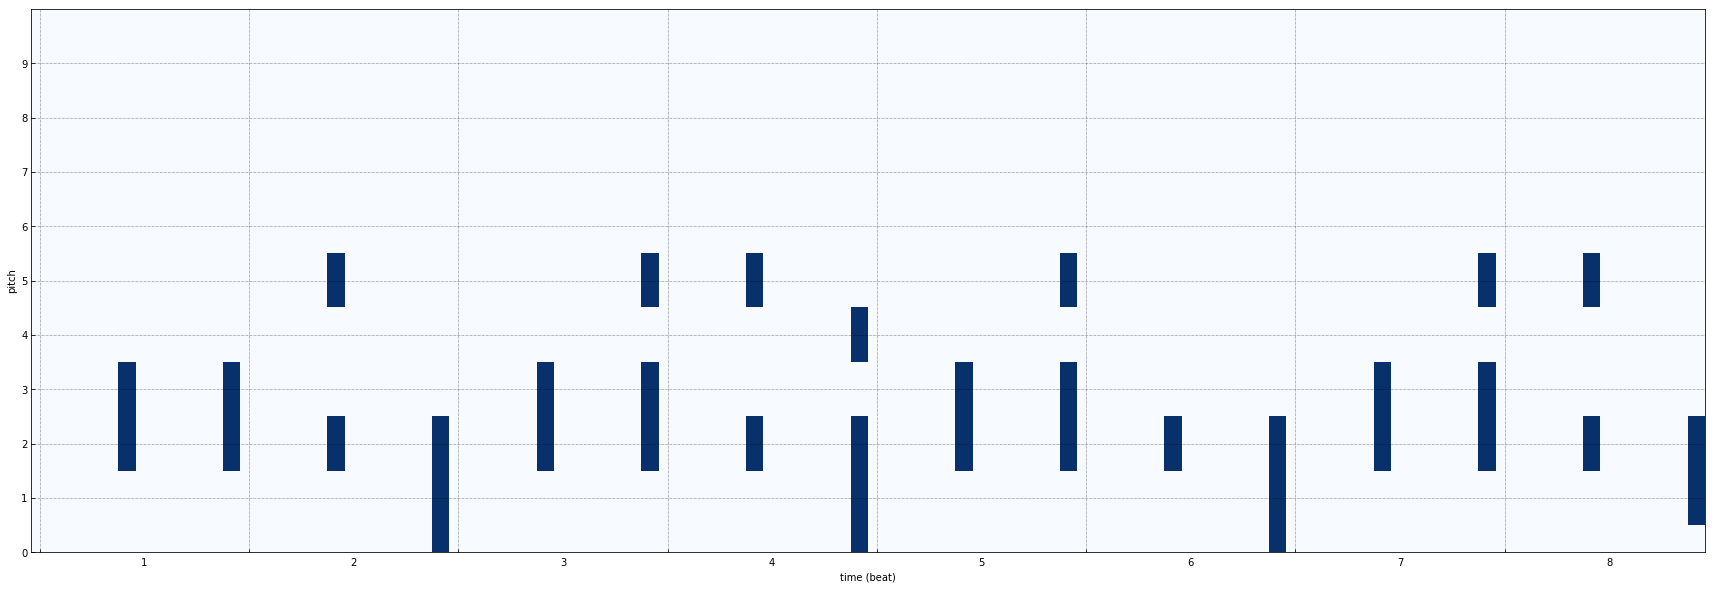

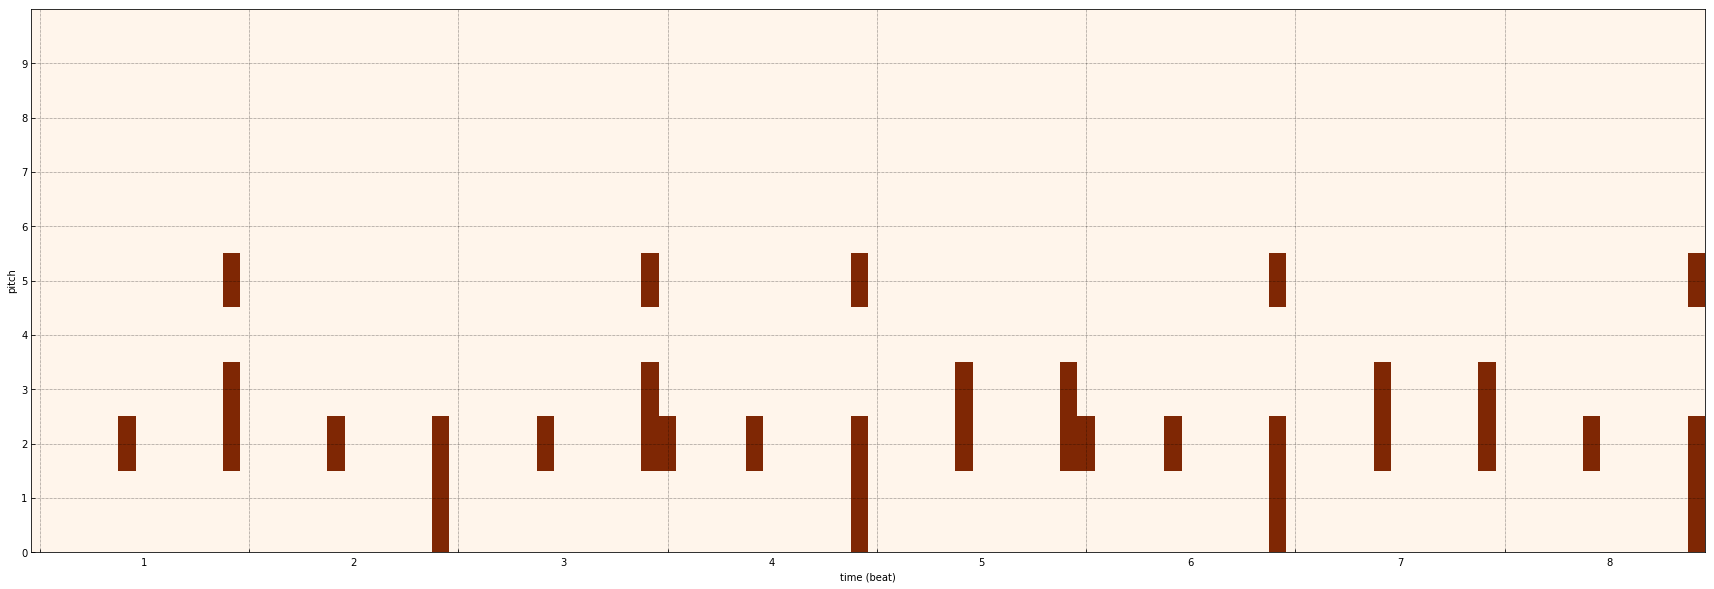

0.99089676 2.0197533e-05


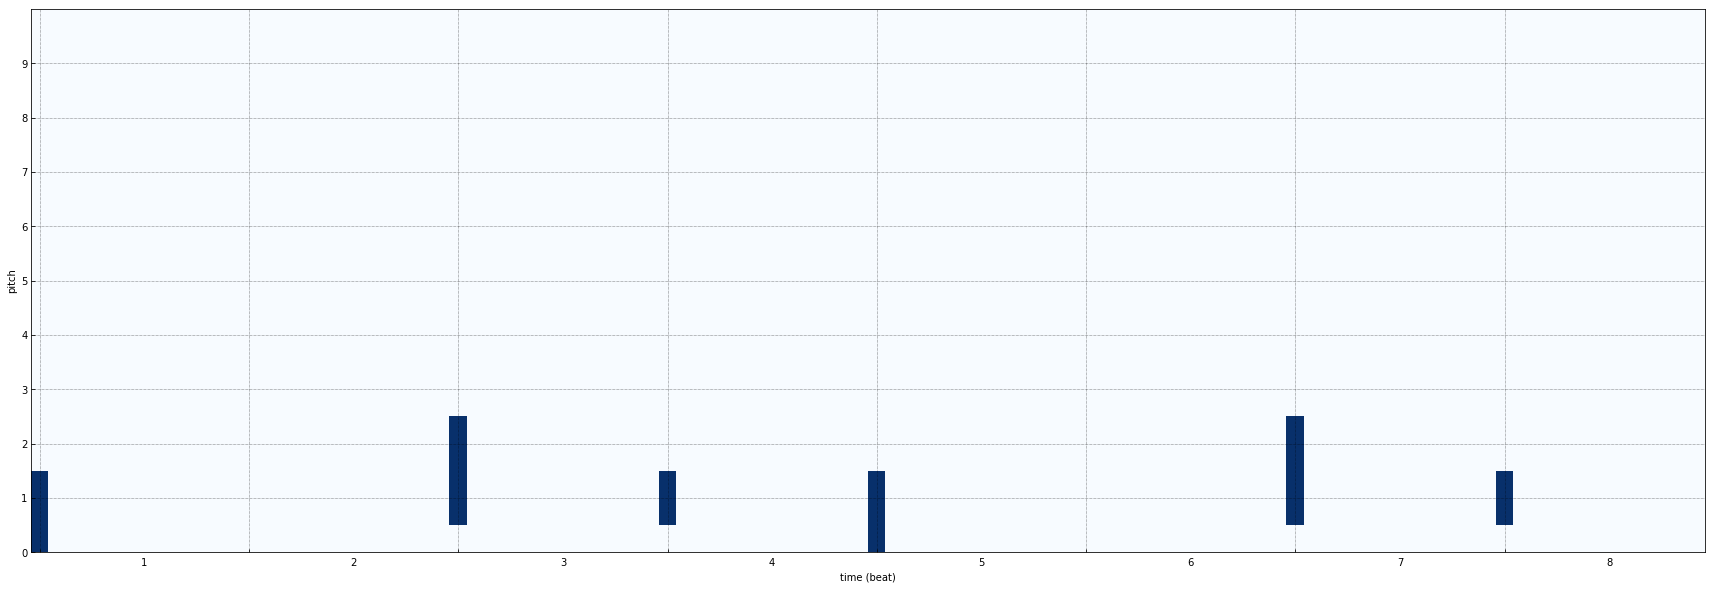

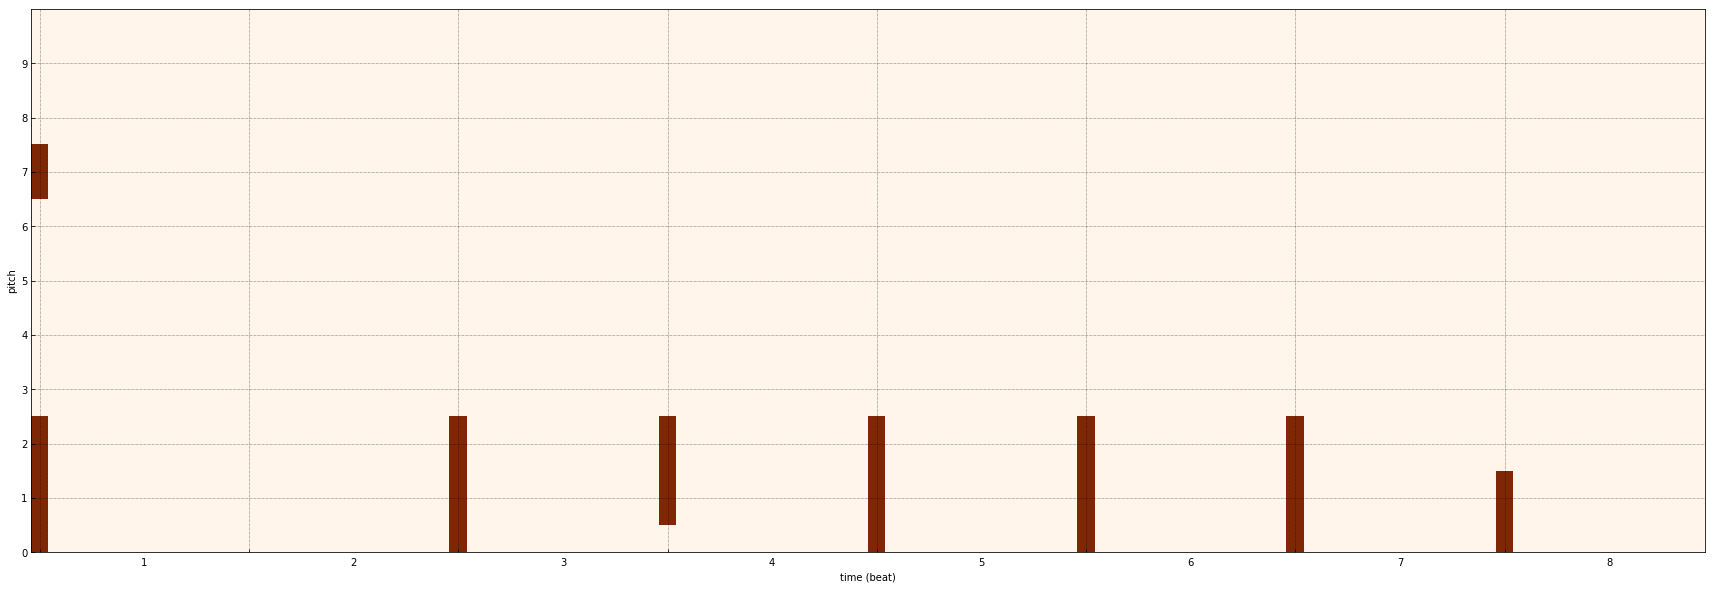

0.9750922 1.6383672e-07


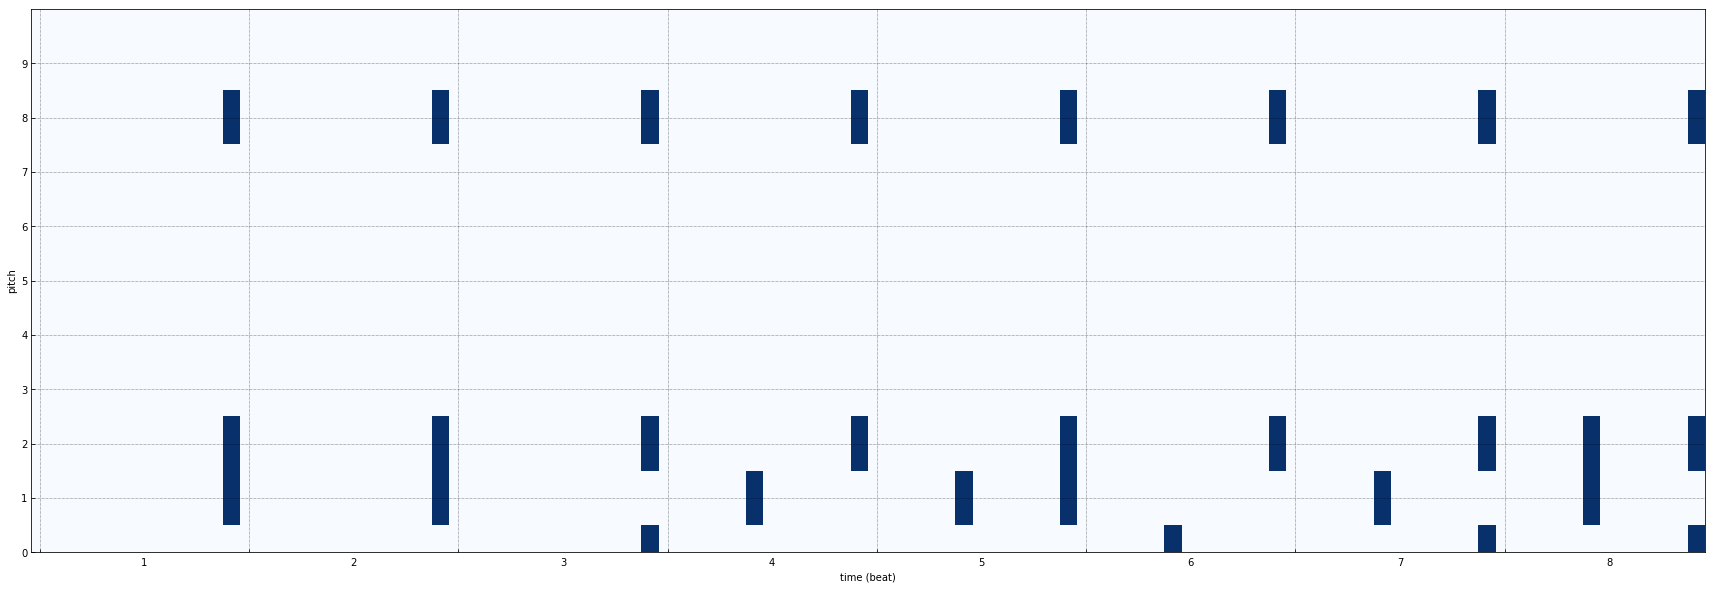

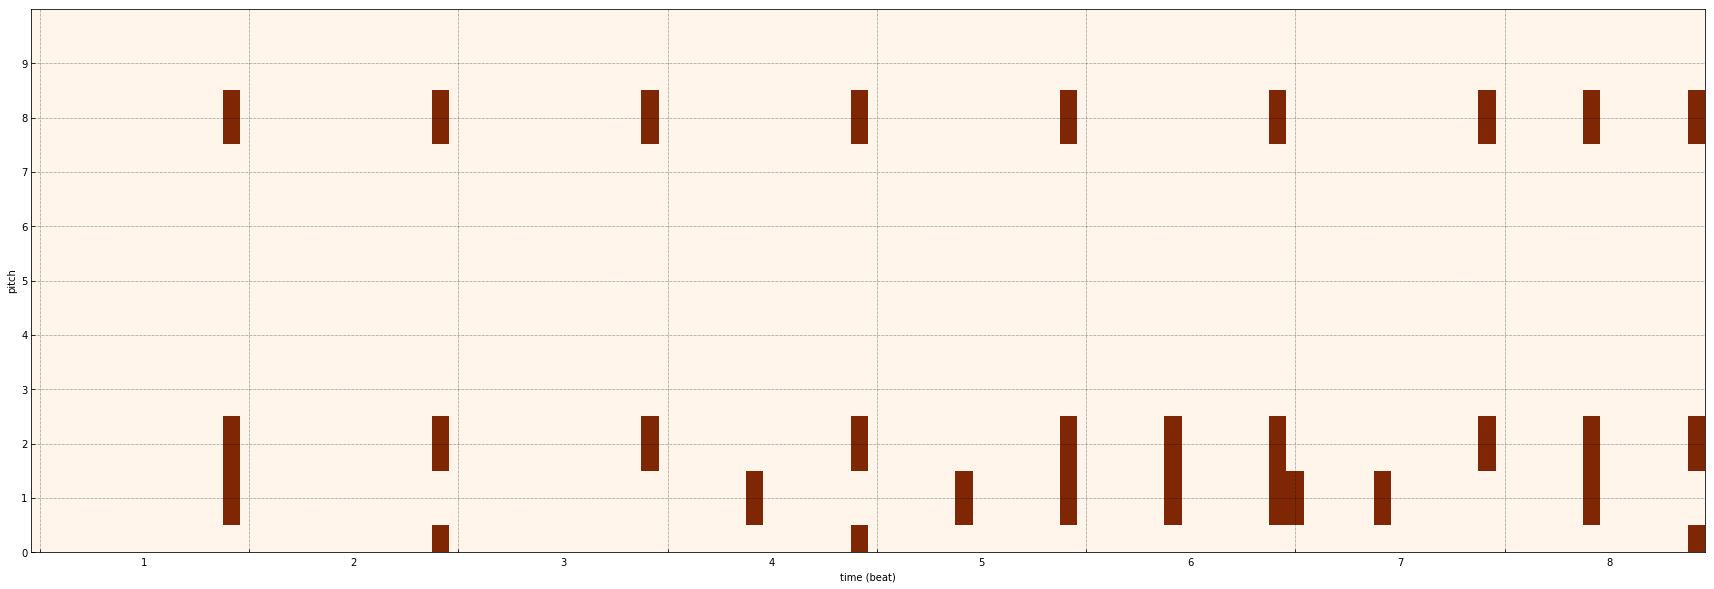

0.9901636 2.2372365e-05


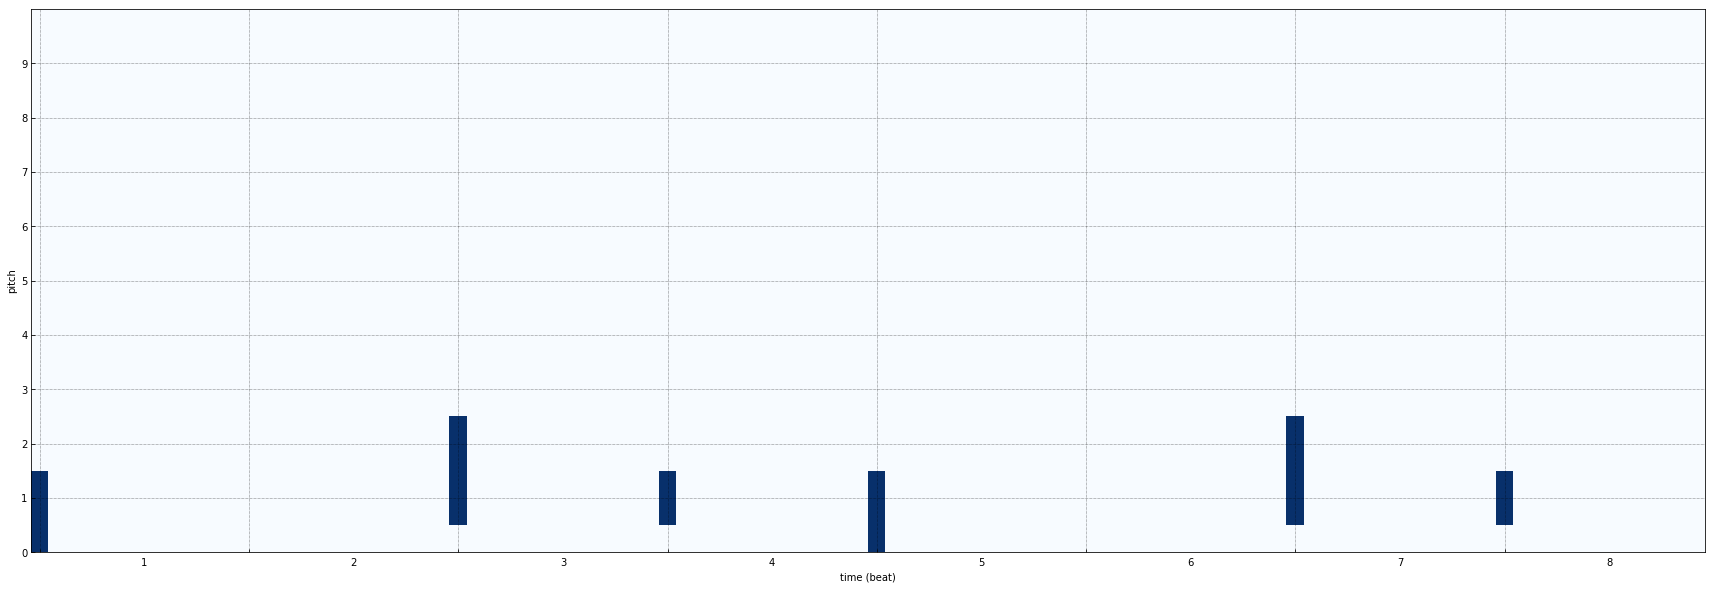

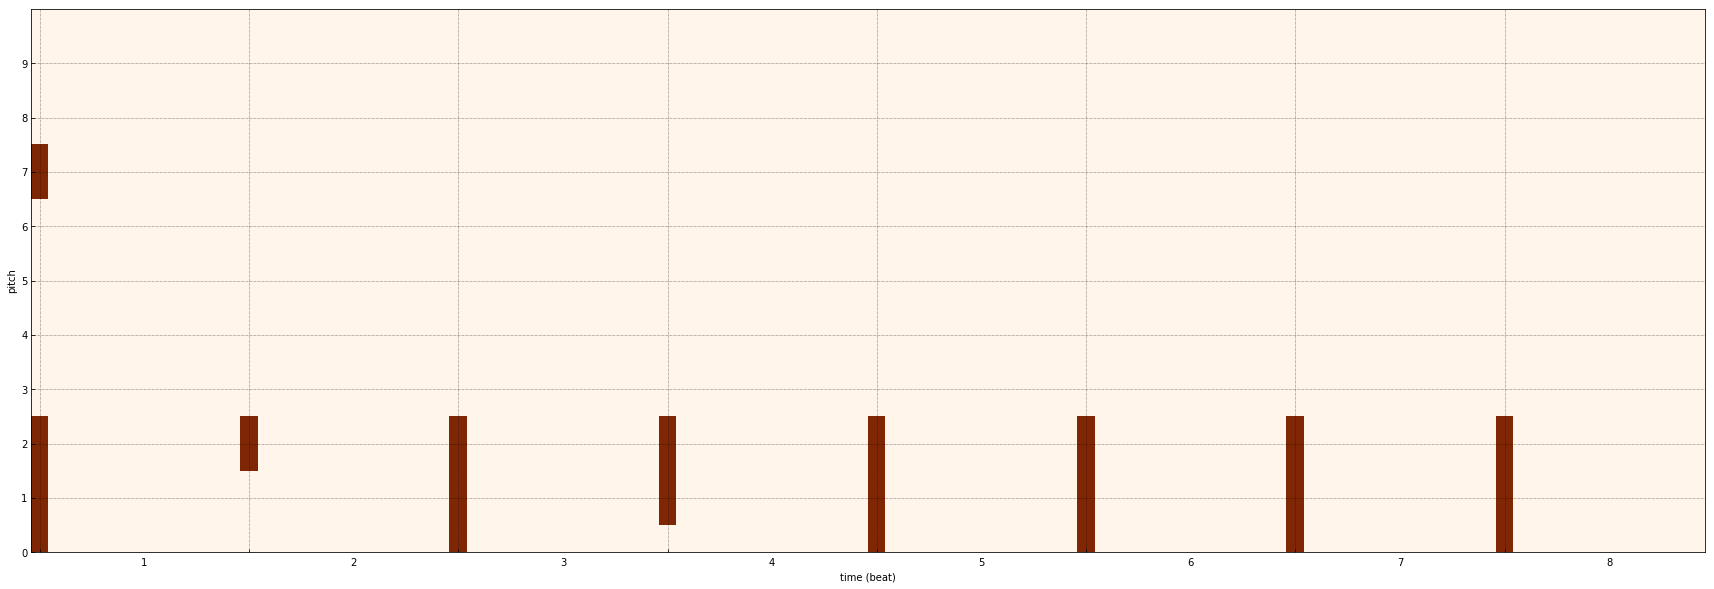

0.9321823 2.1036292e-05


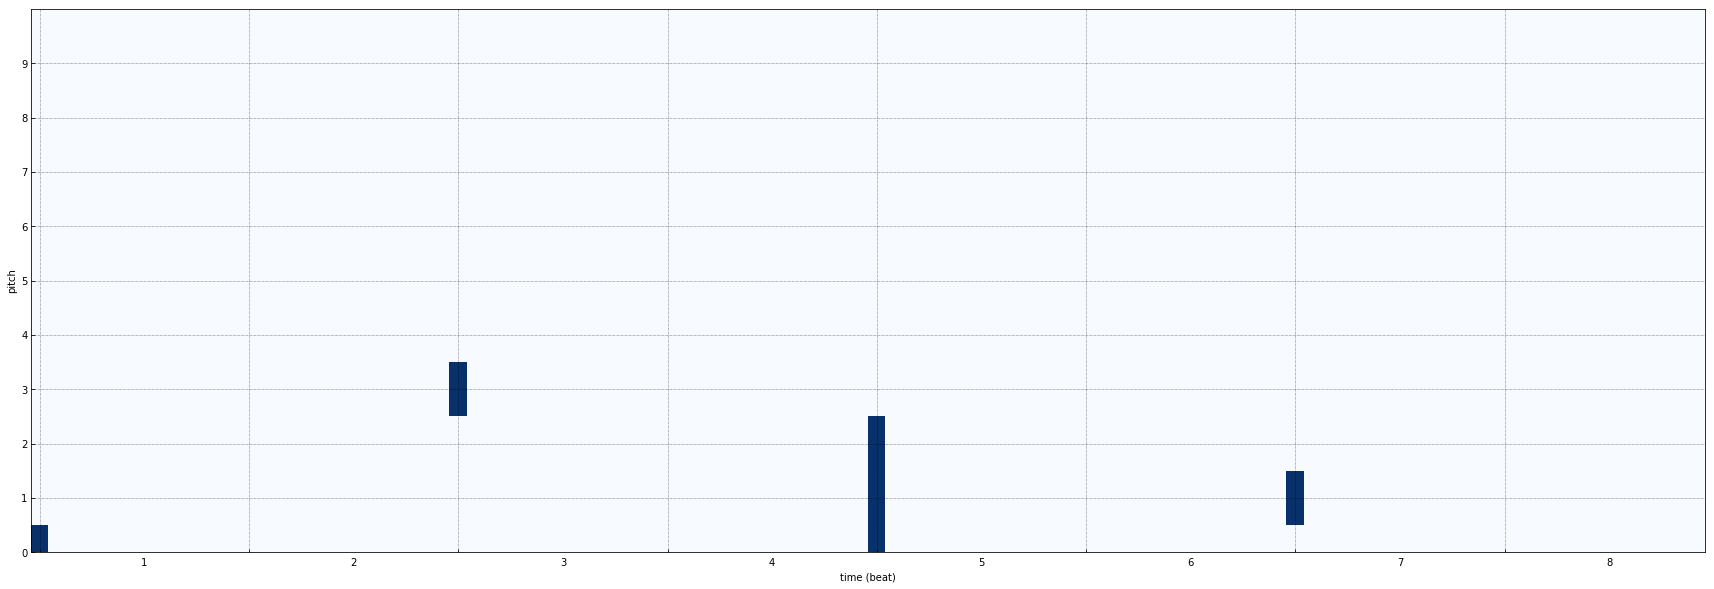

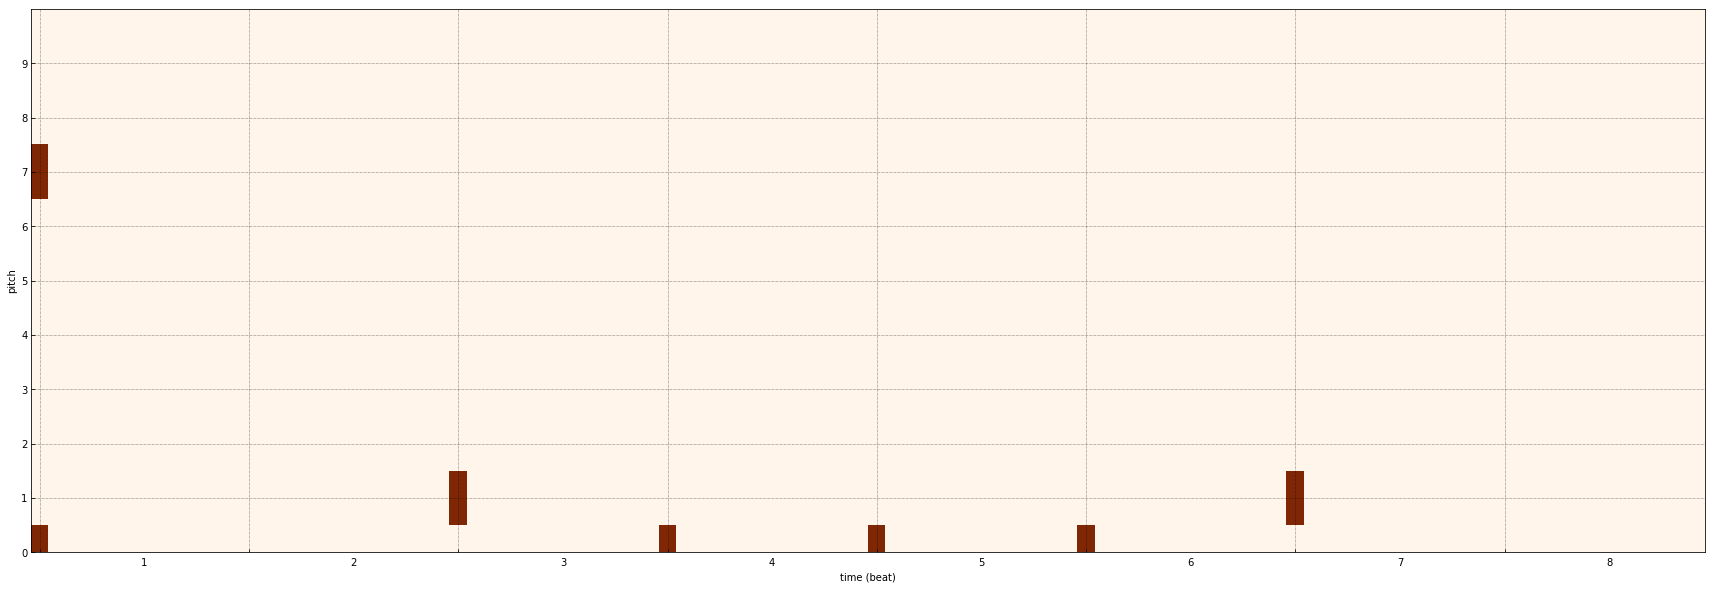

0.9923389 3.1645748e-05


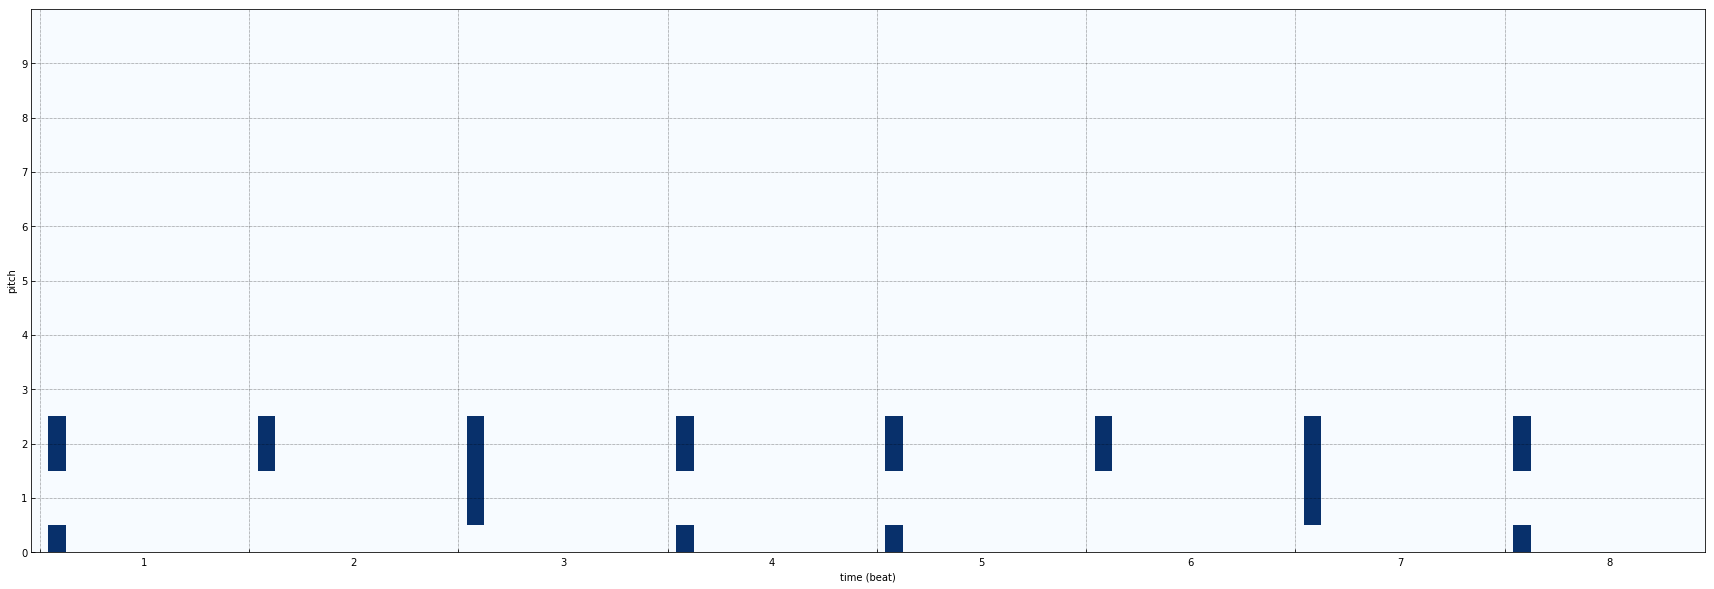

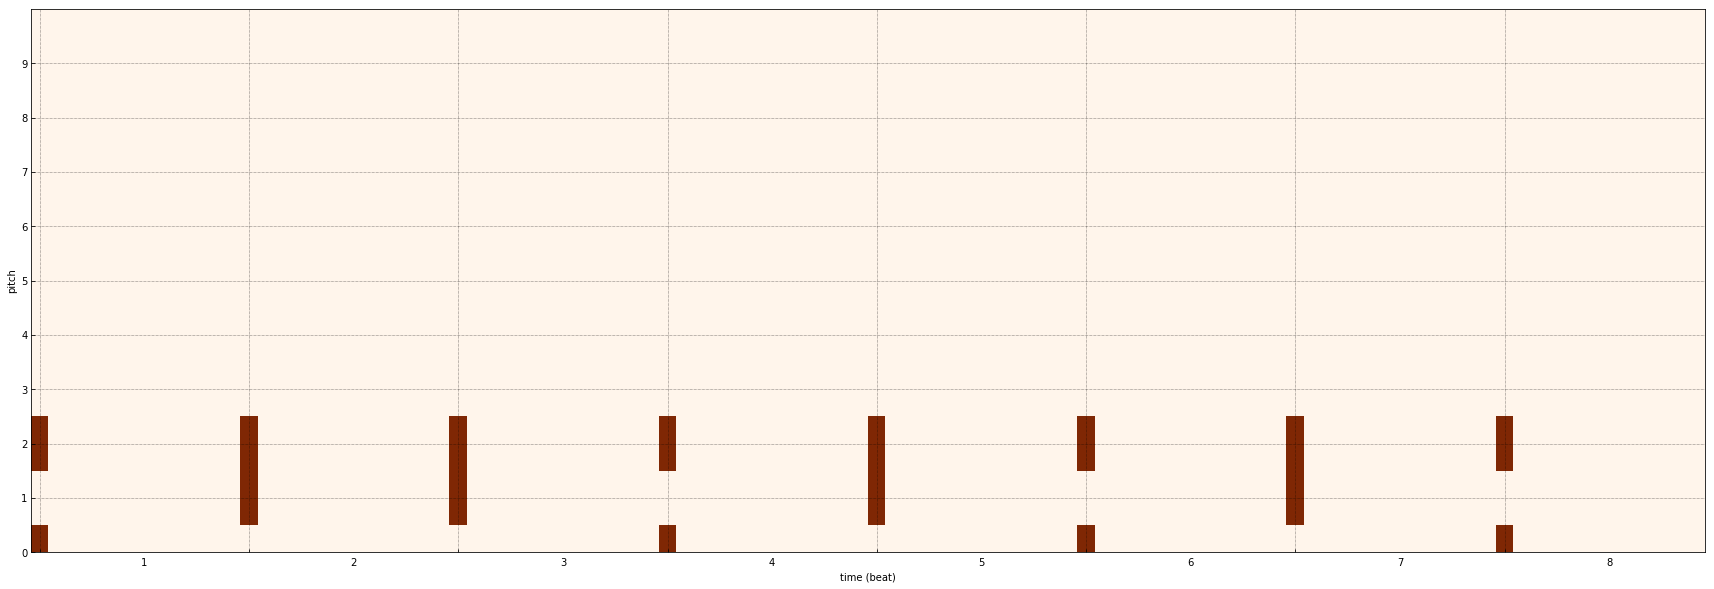

0.9728986 1.4271393e-07


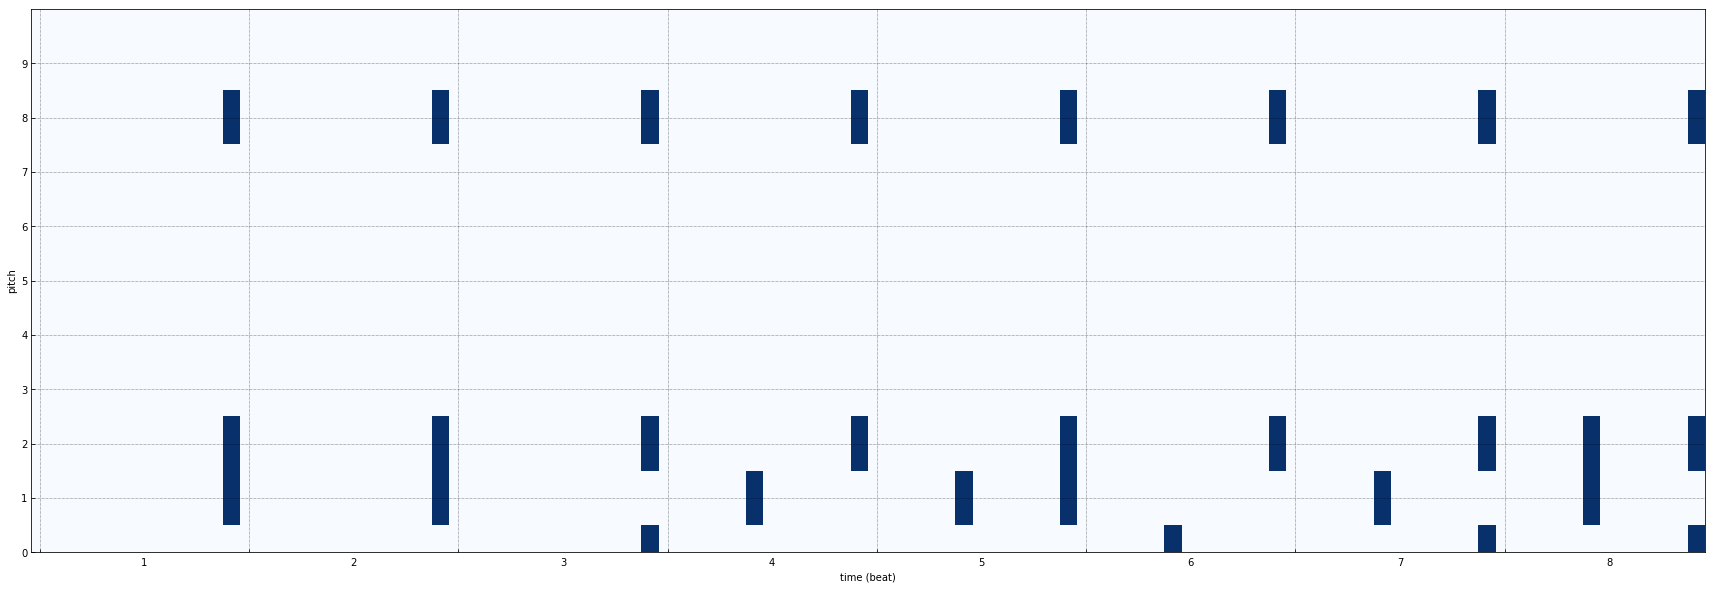

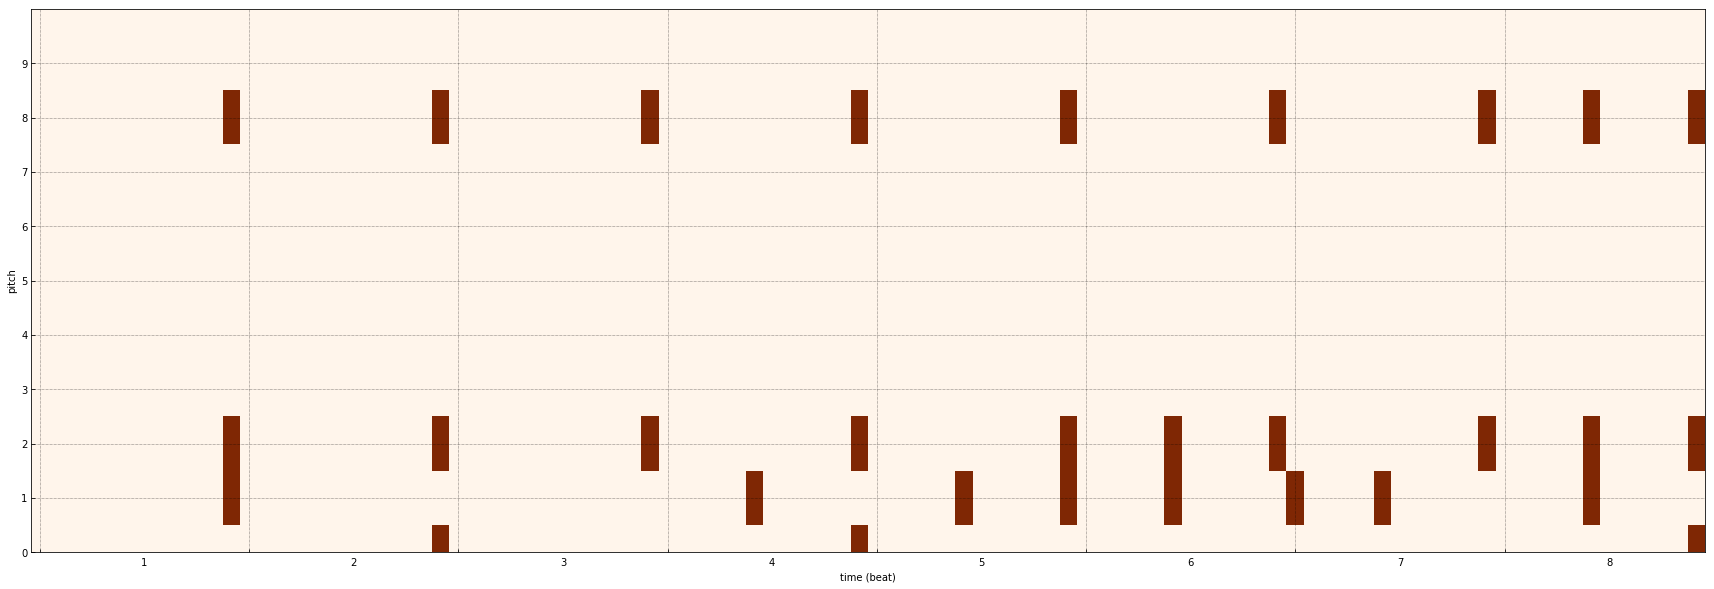

0.99703467 1.3296263e-07


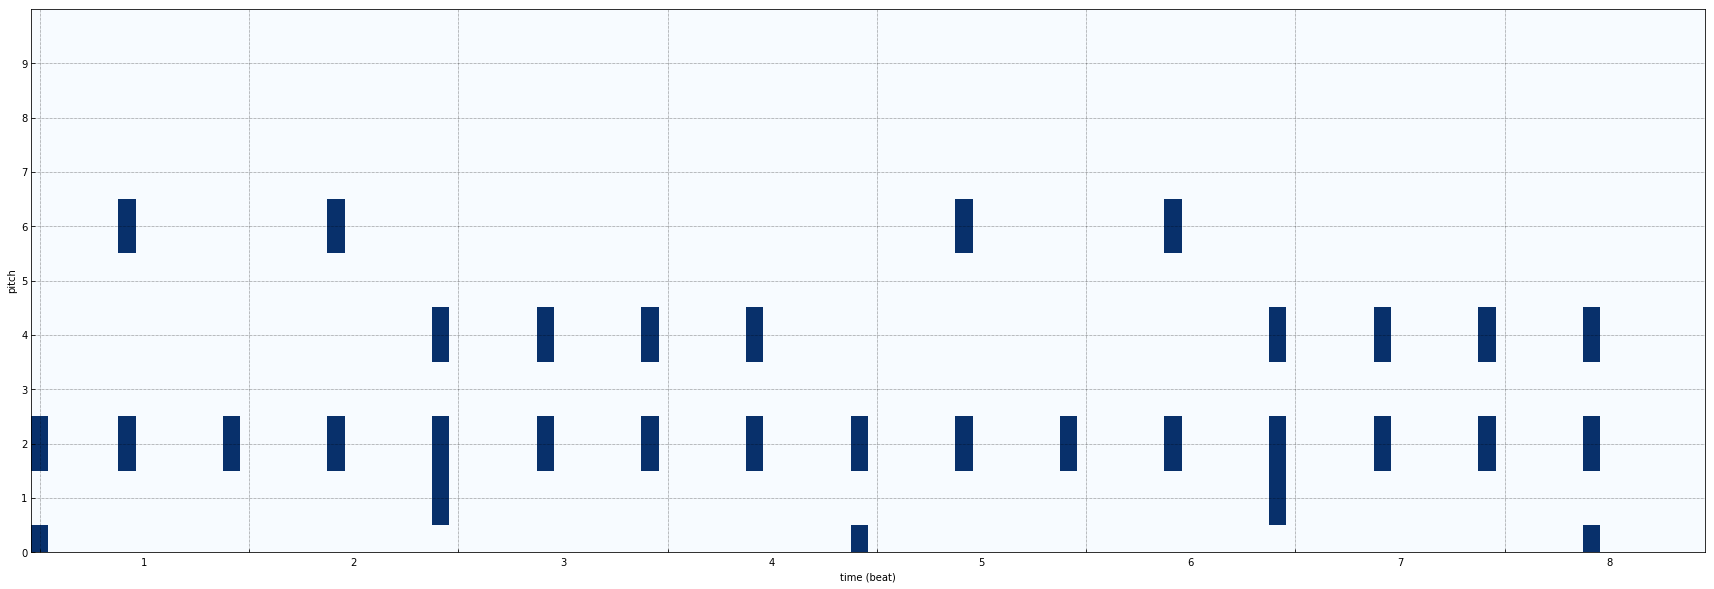

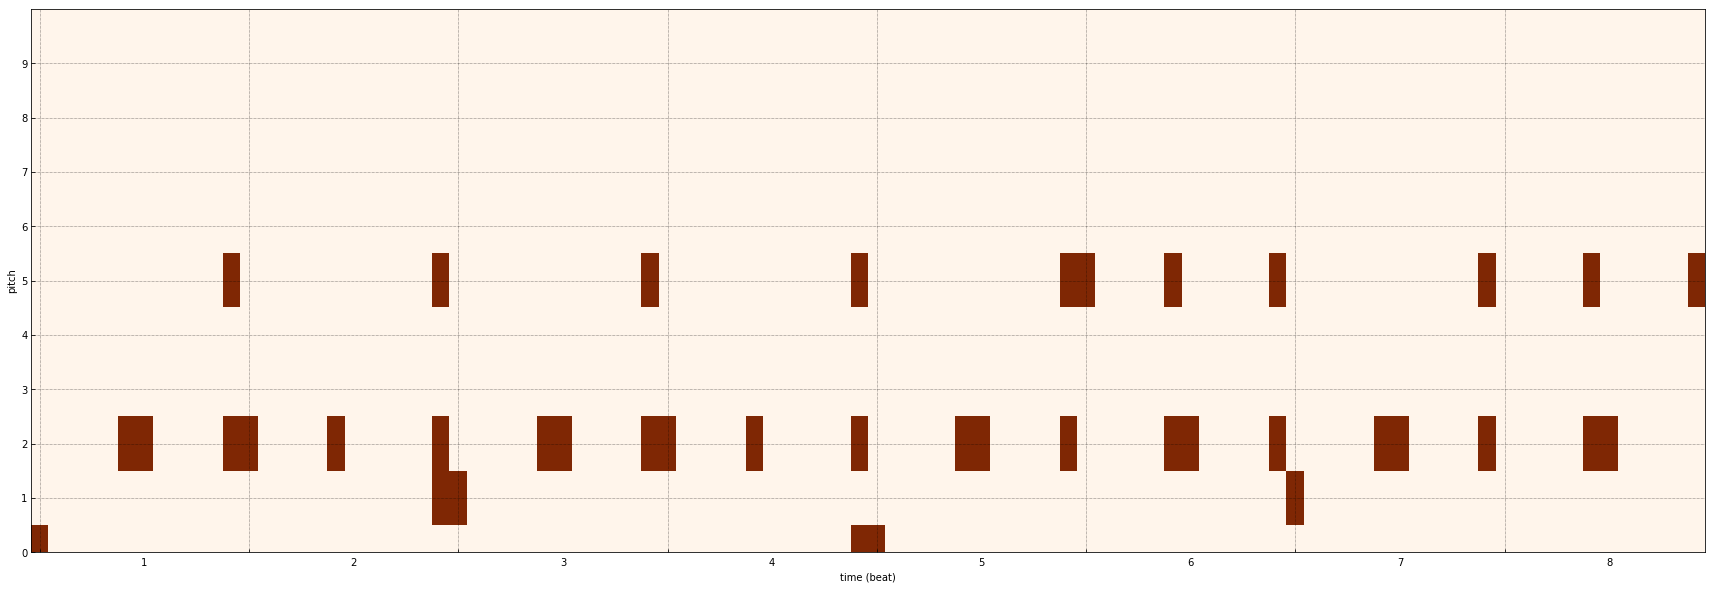

0.9999995 3.4520153e-07


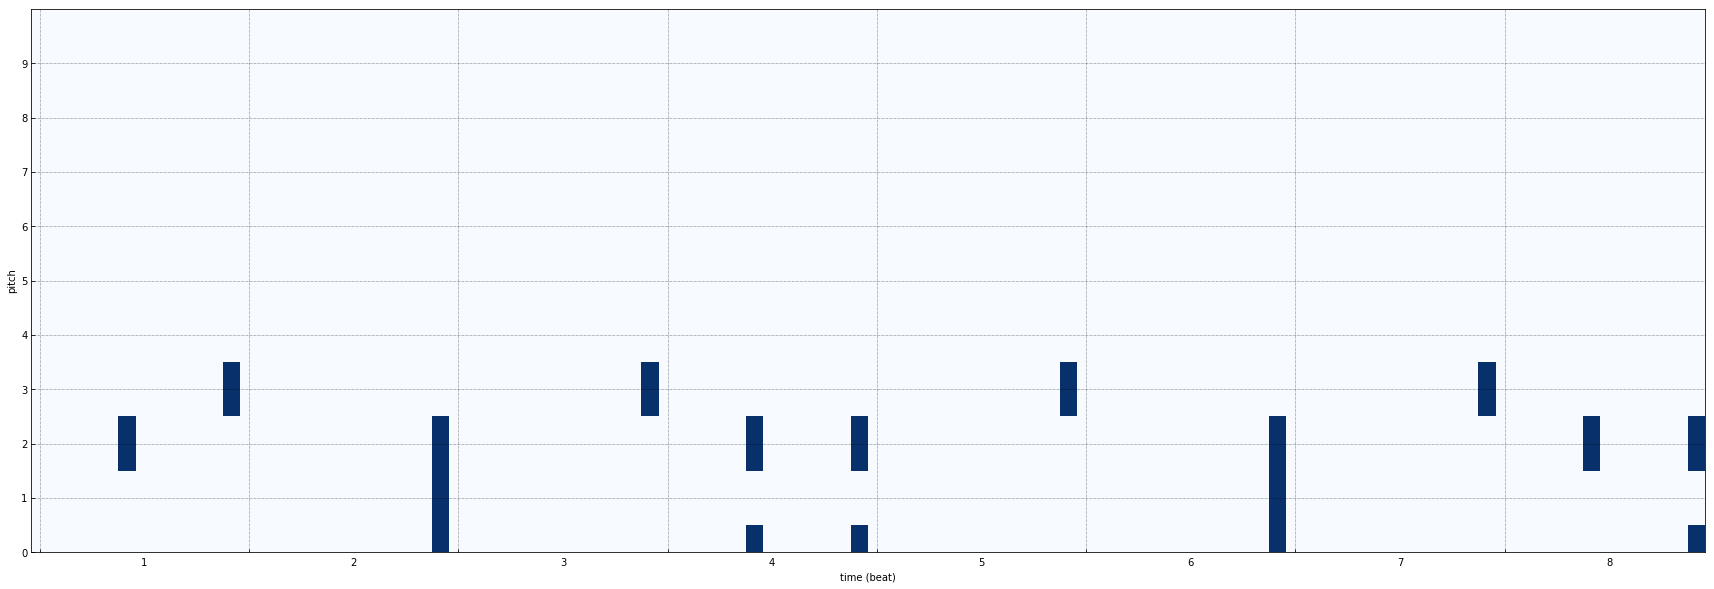

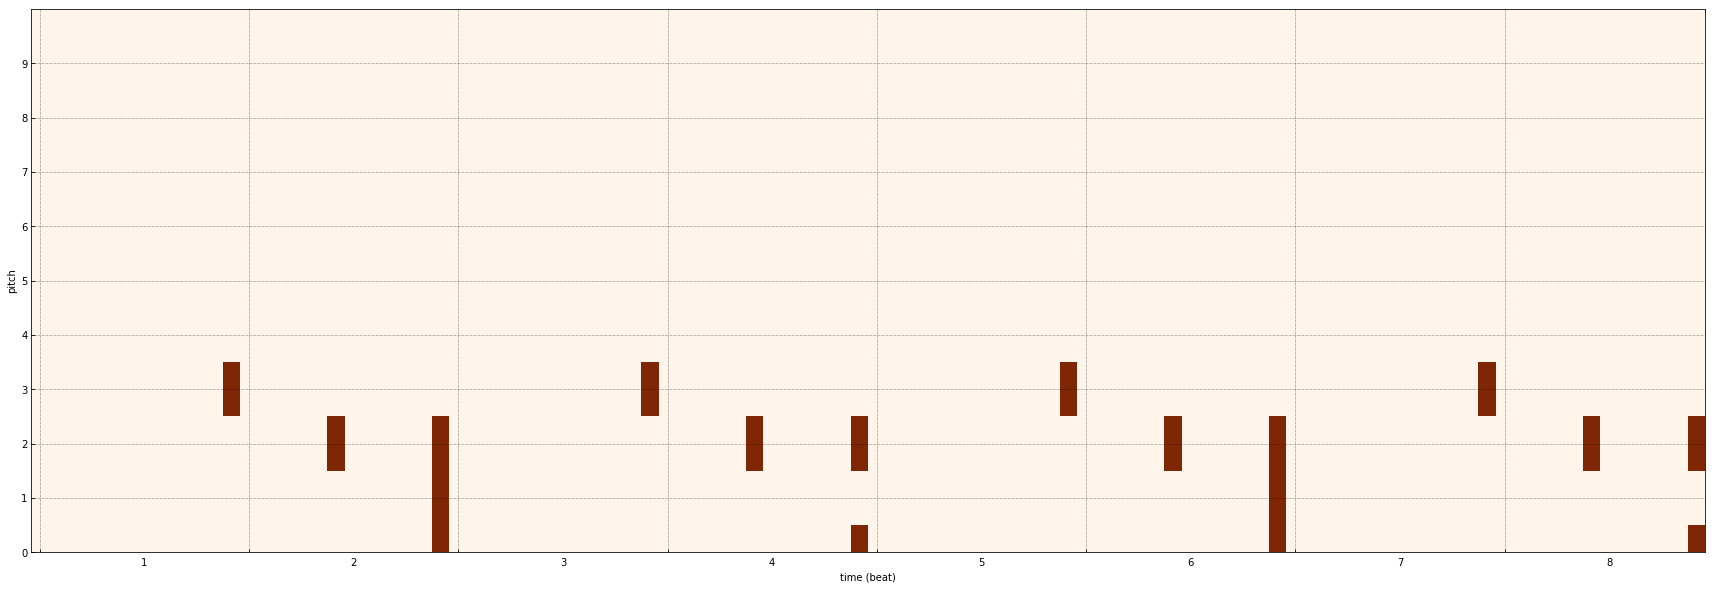

0.99667823 7.0928604e-06


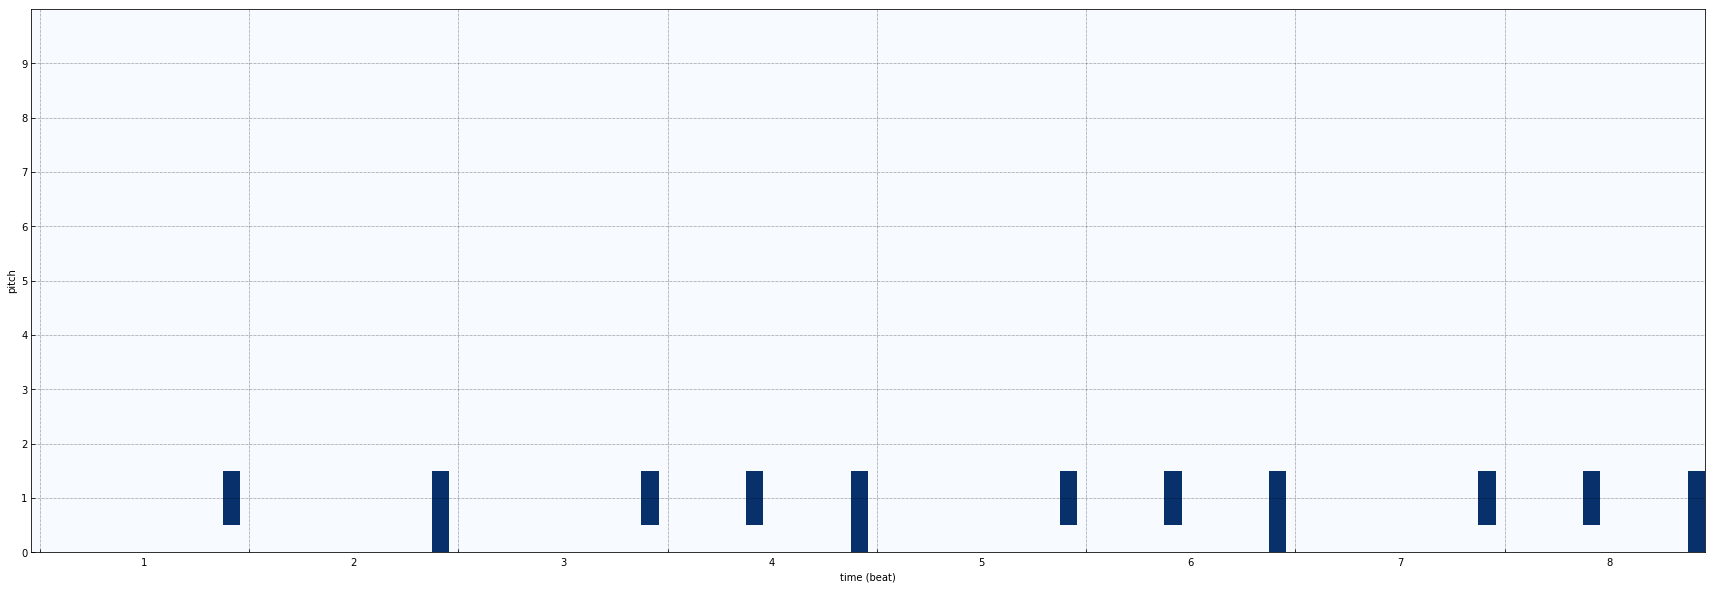

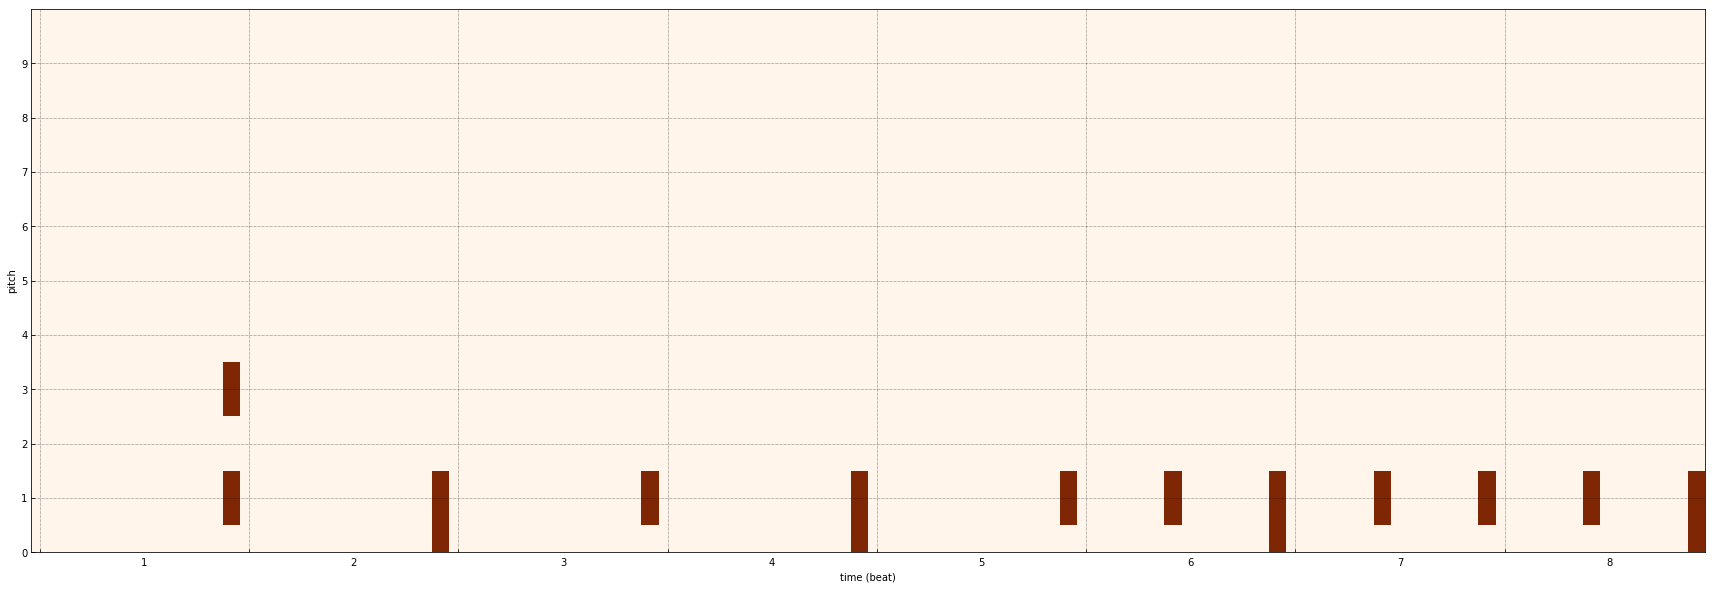

0.2924327 1.5797244e-05


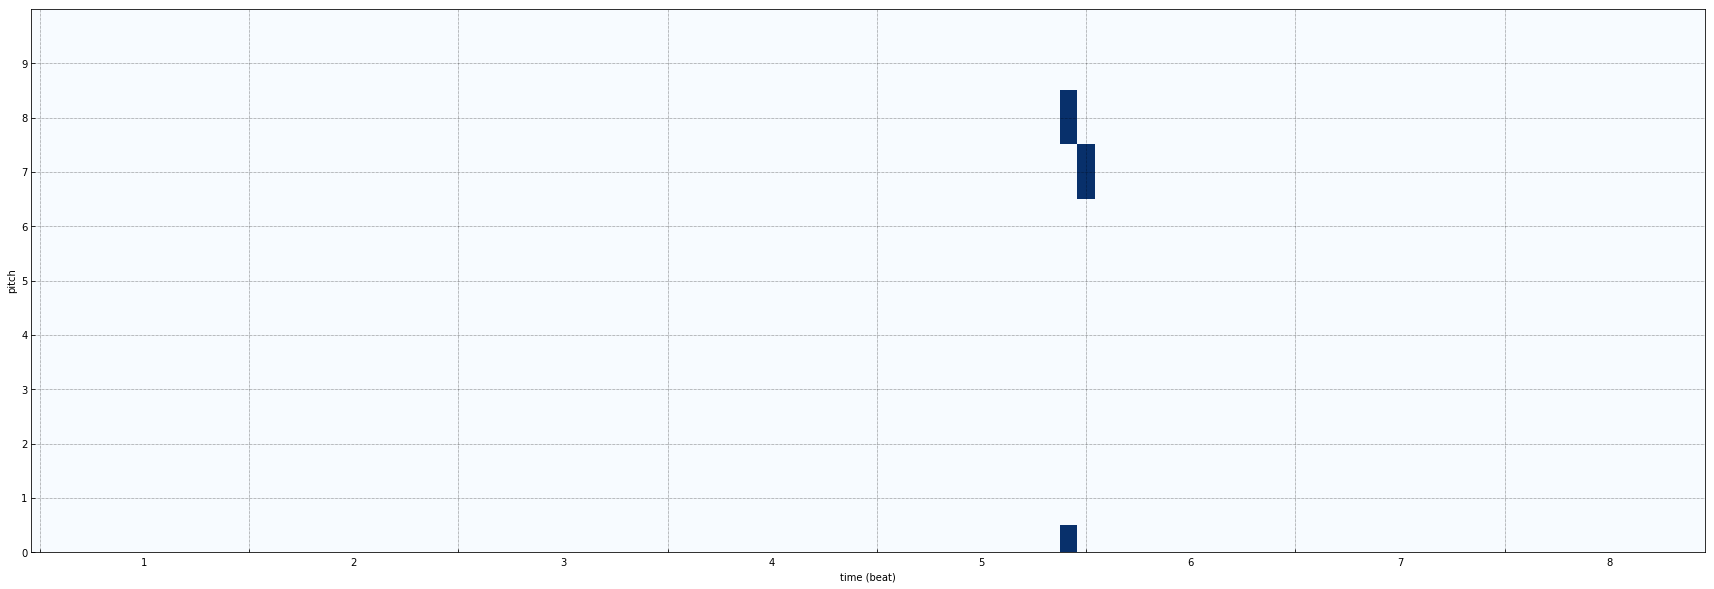

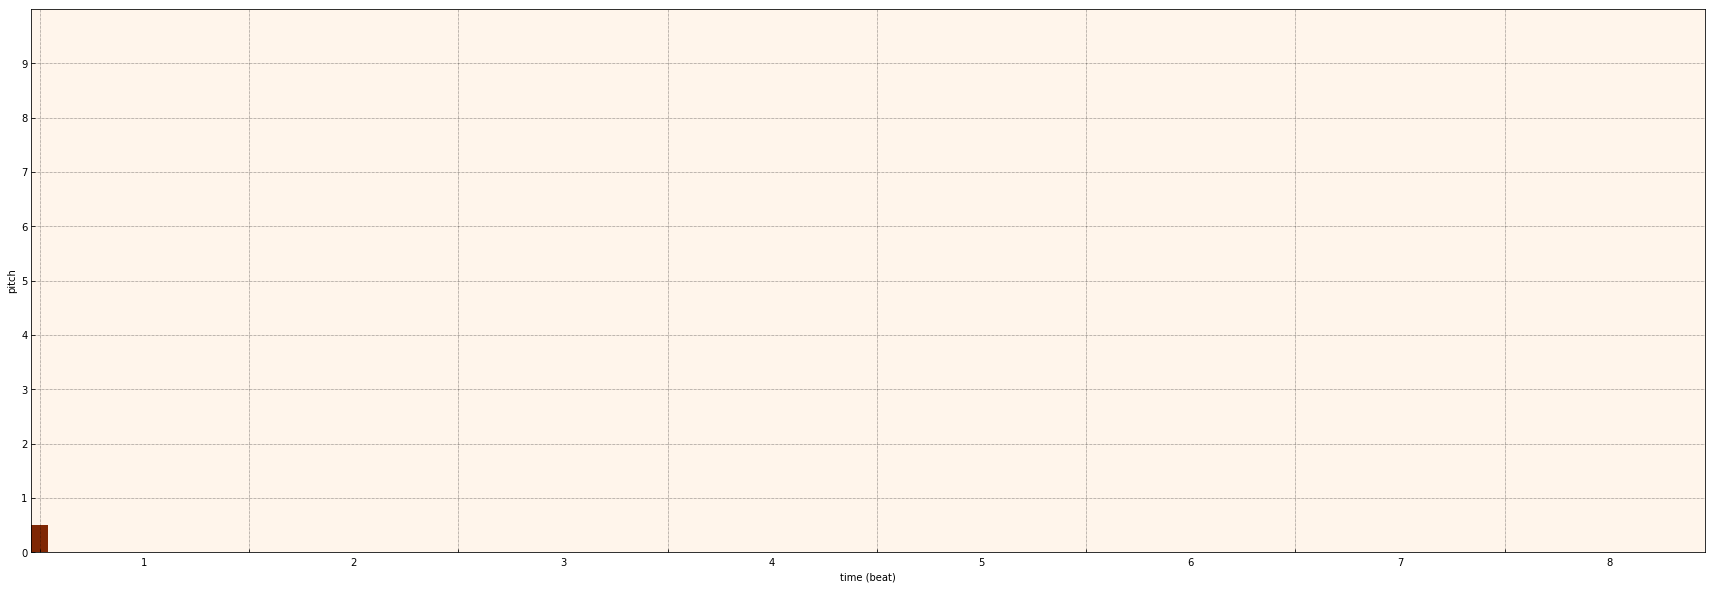

0.9464514 5.0690185e-05


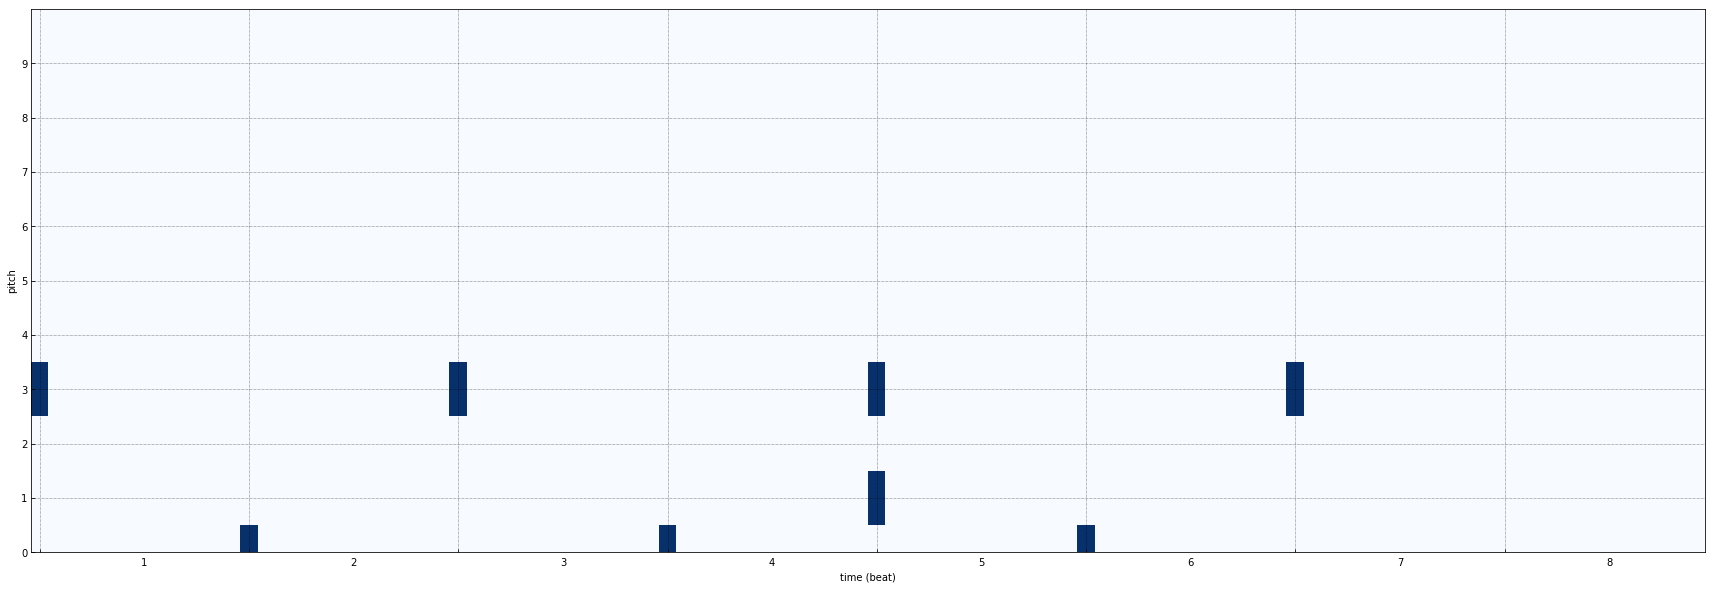

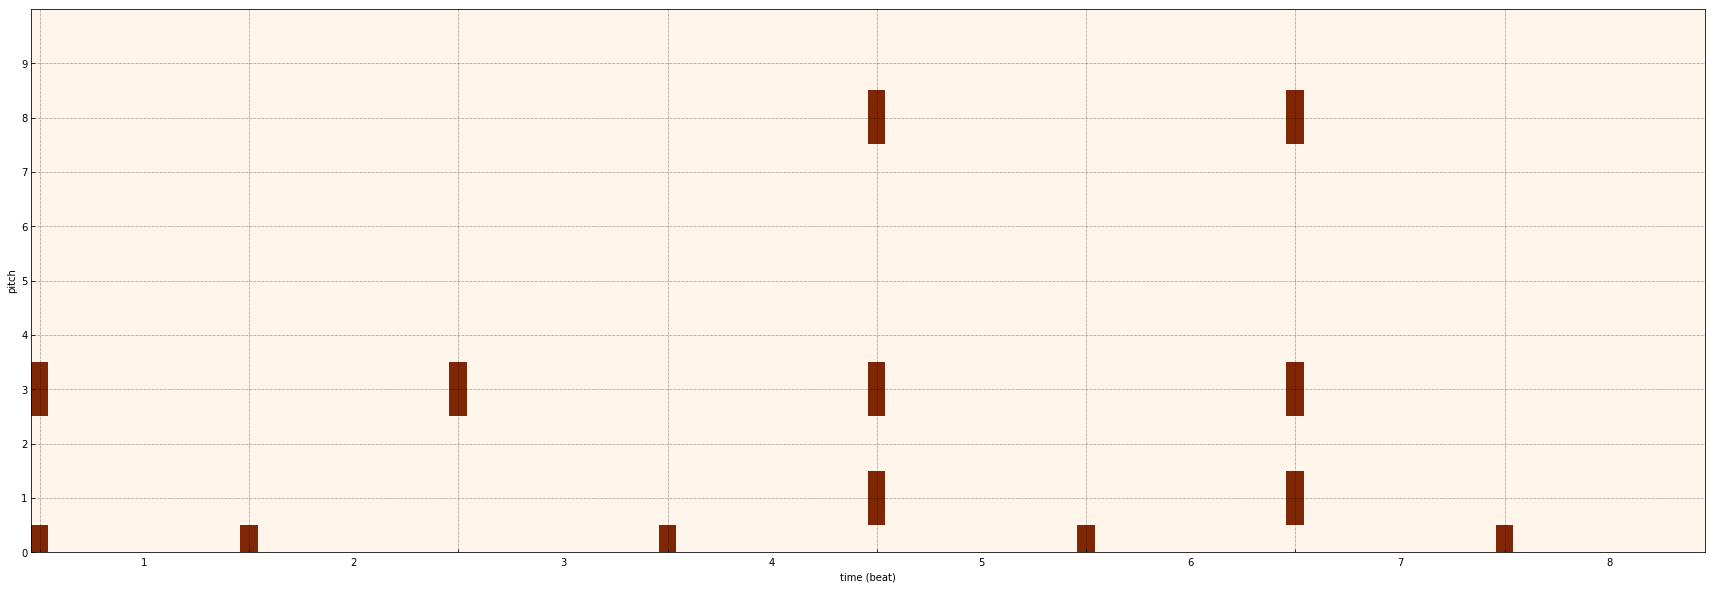

0.25739986 3.1668114e-07


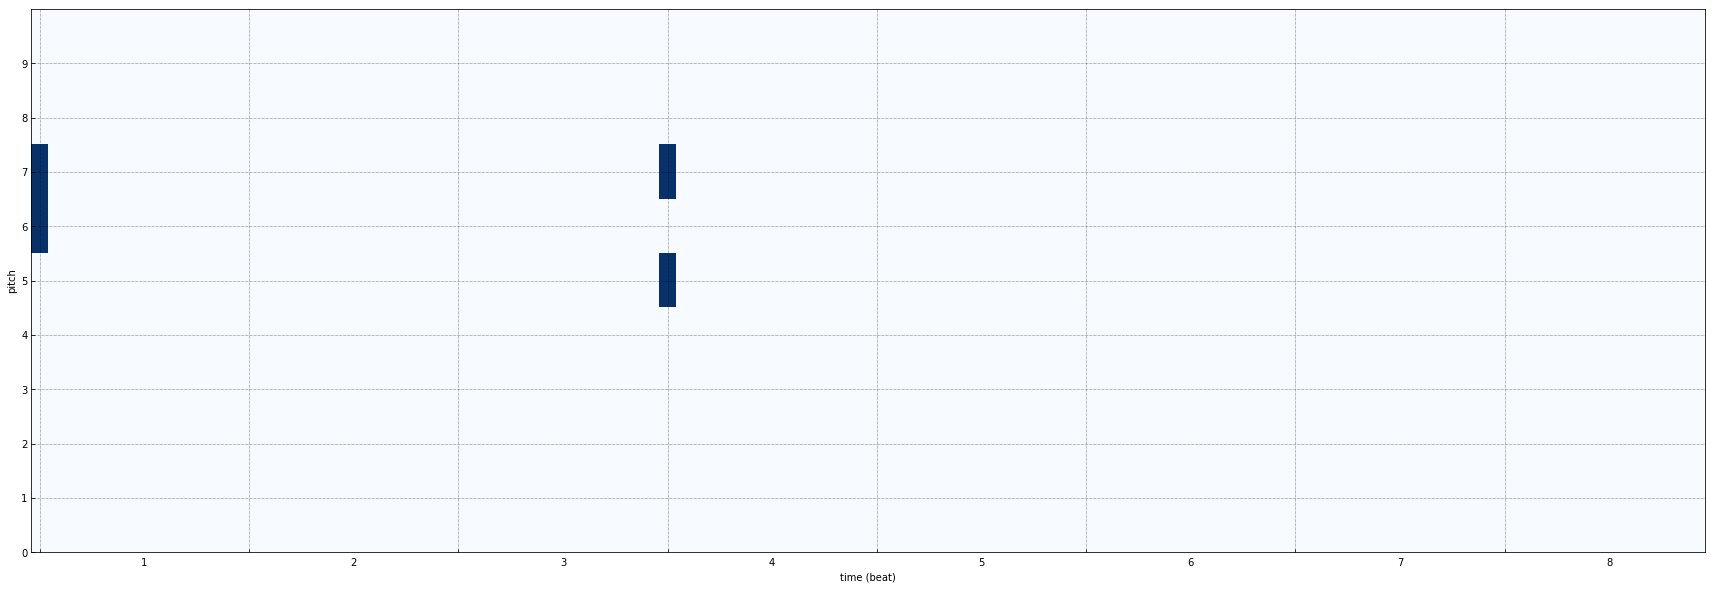

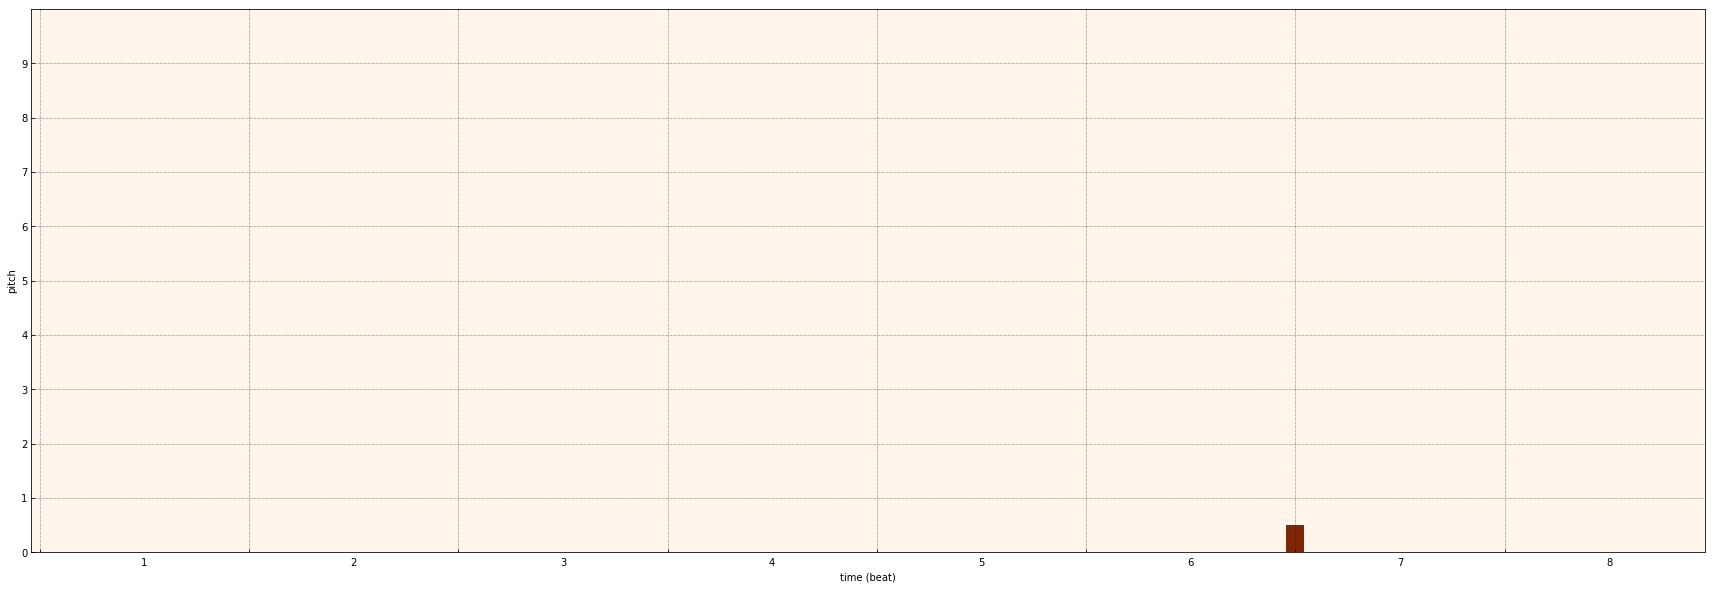

0.9625552 1.6910212e-07


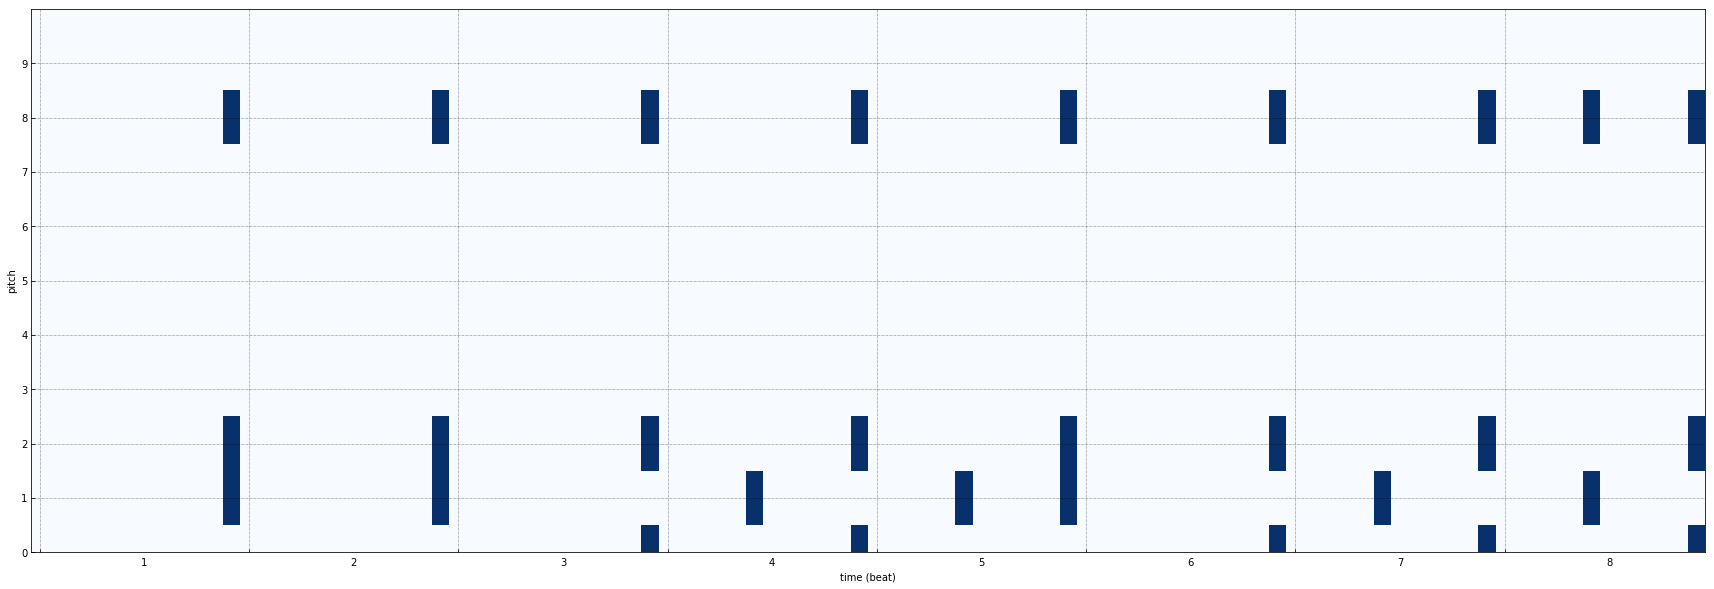

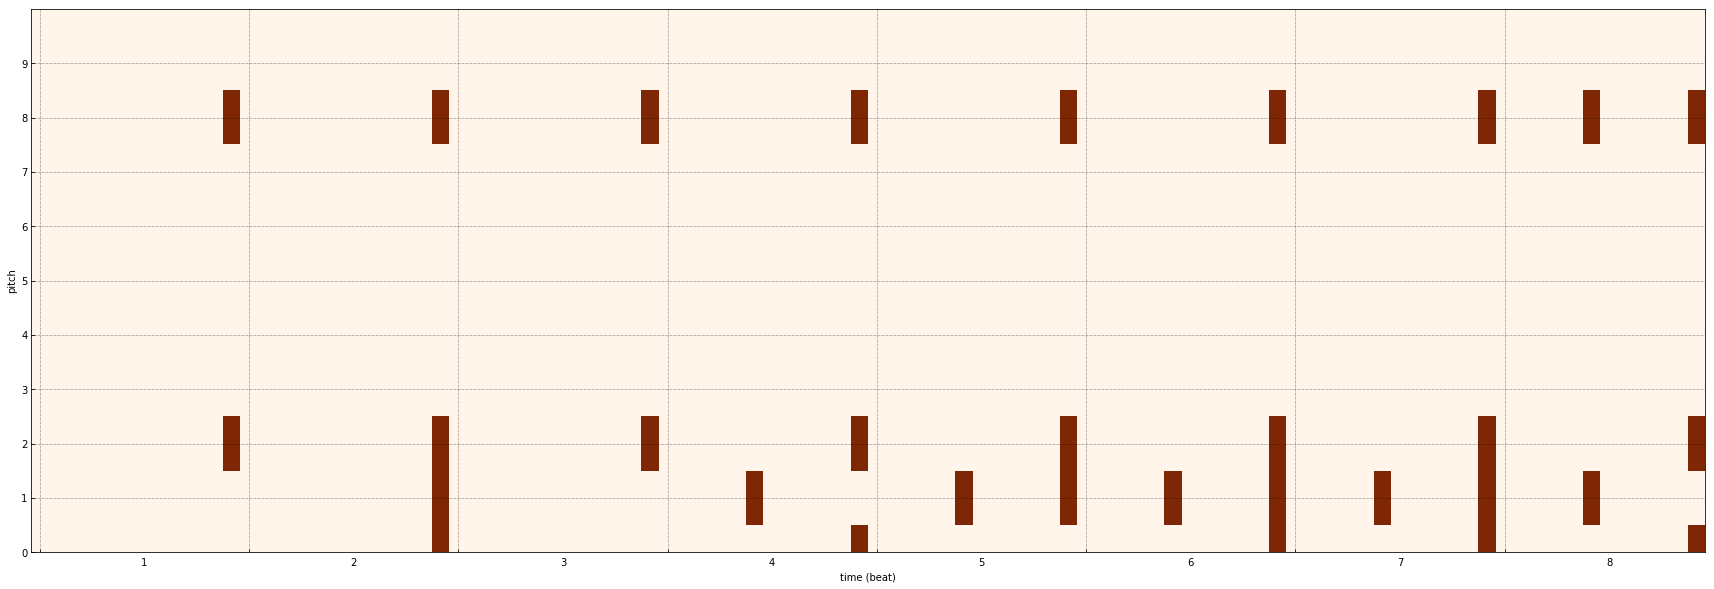

0.98029757 8.78294e-08


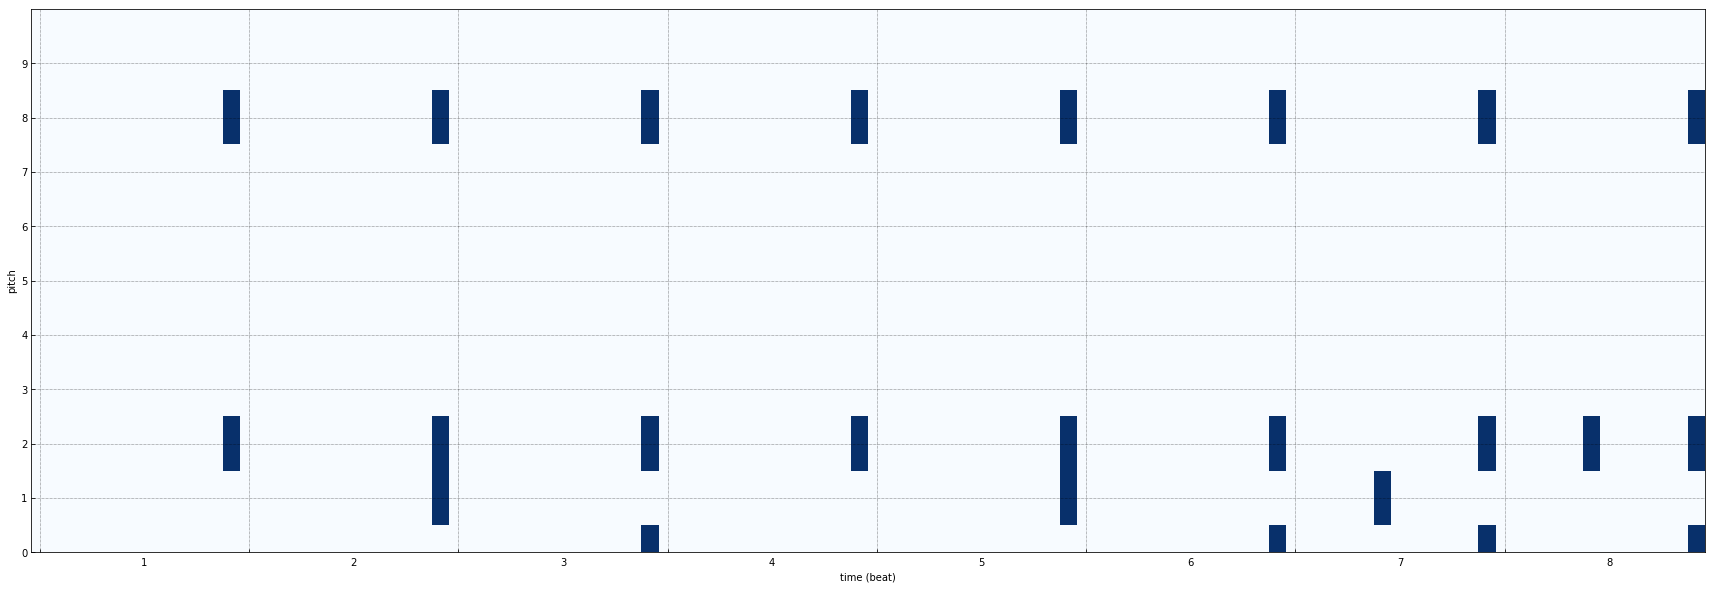

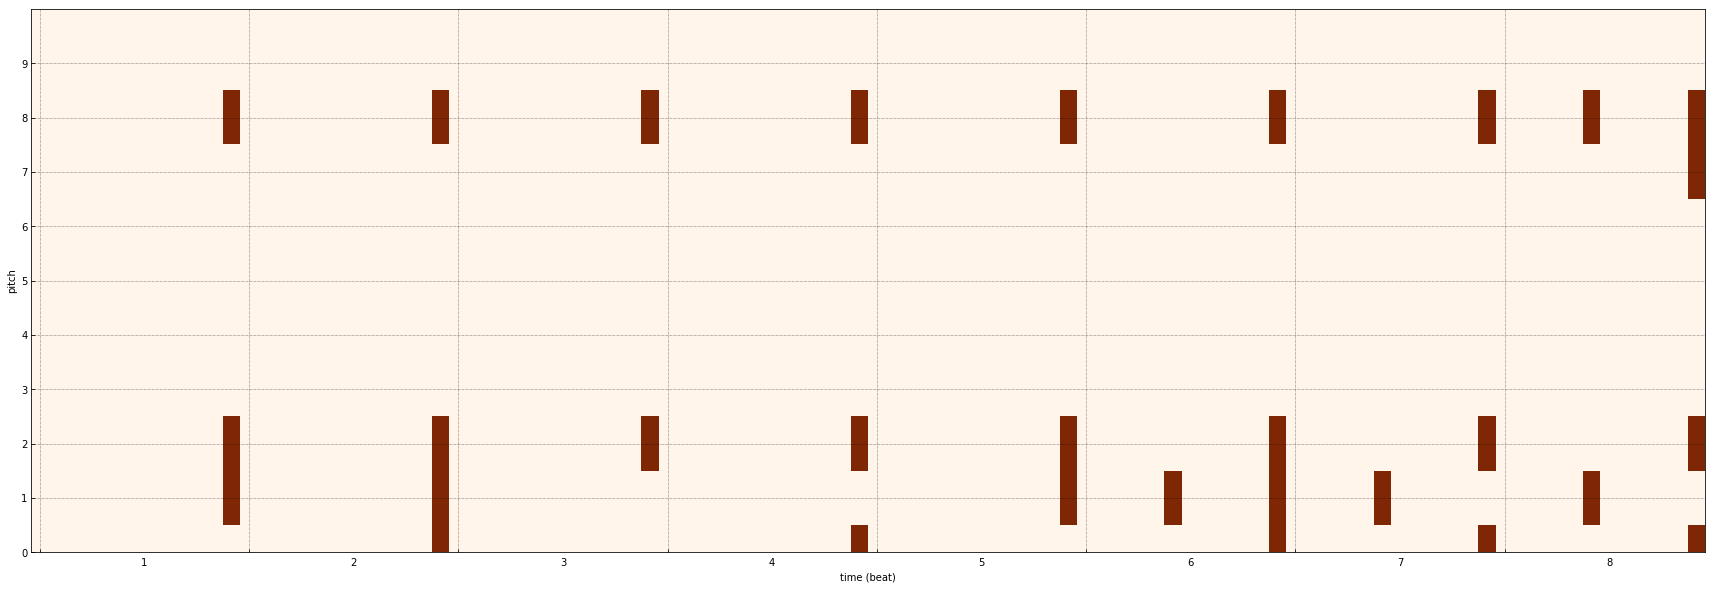

0.35628942 6.666113e-05


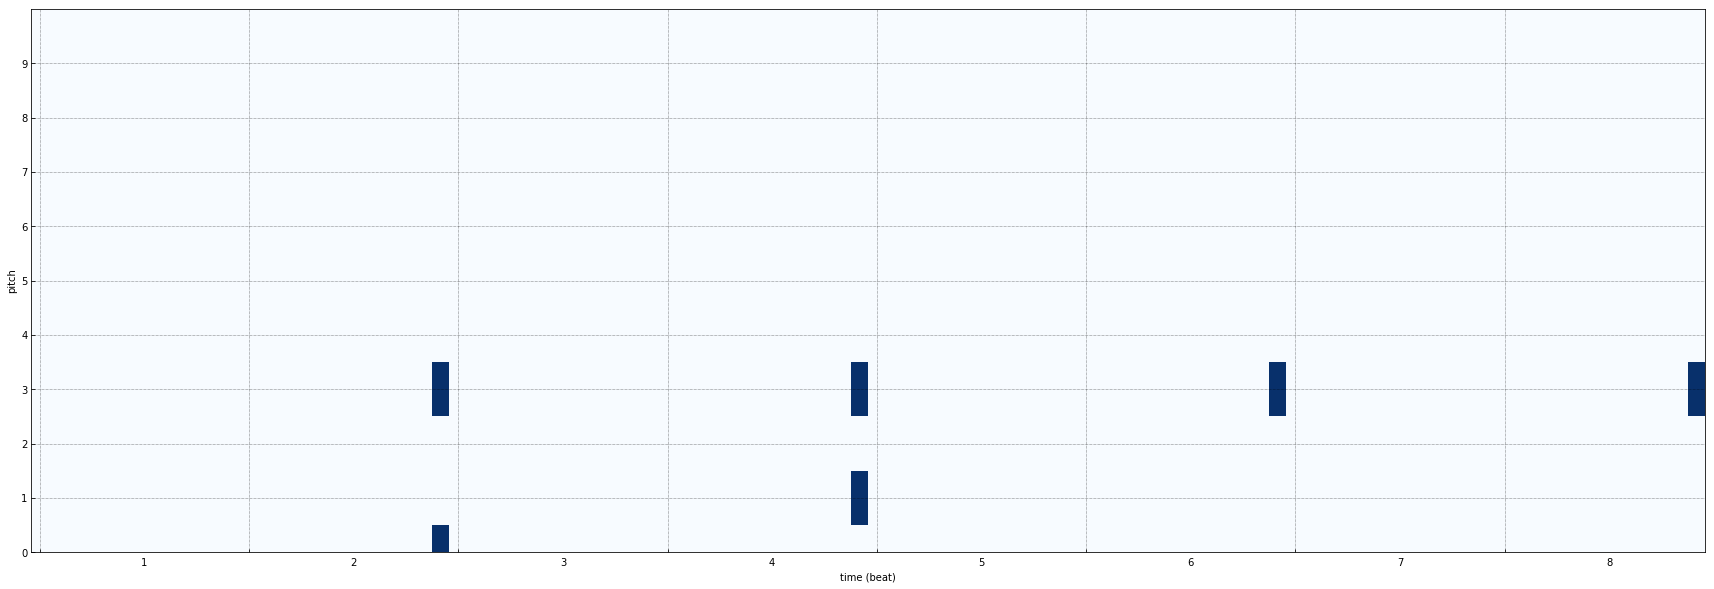

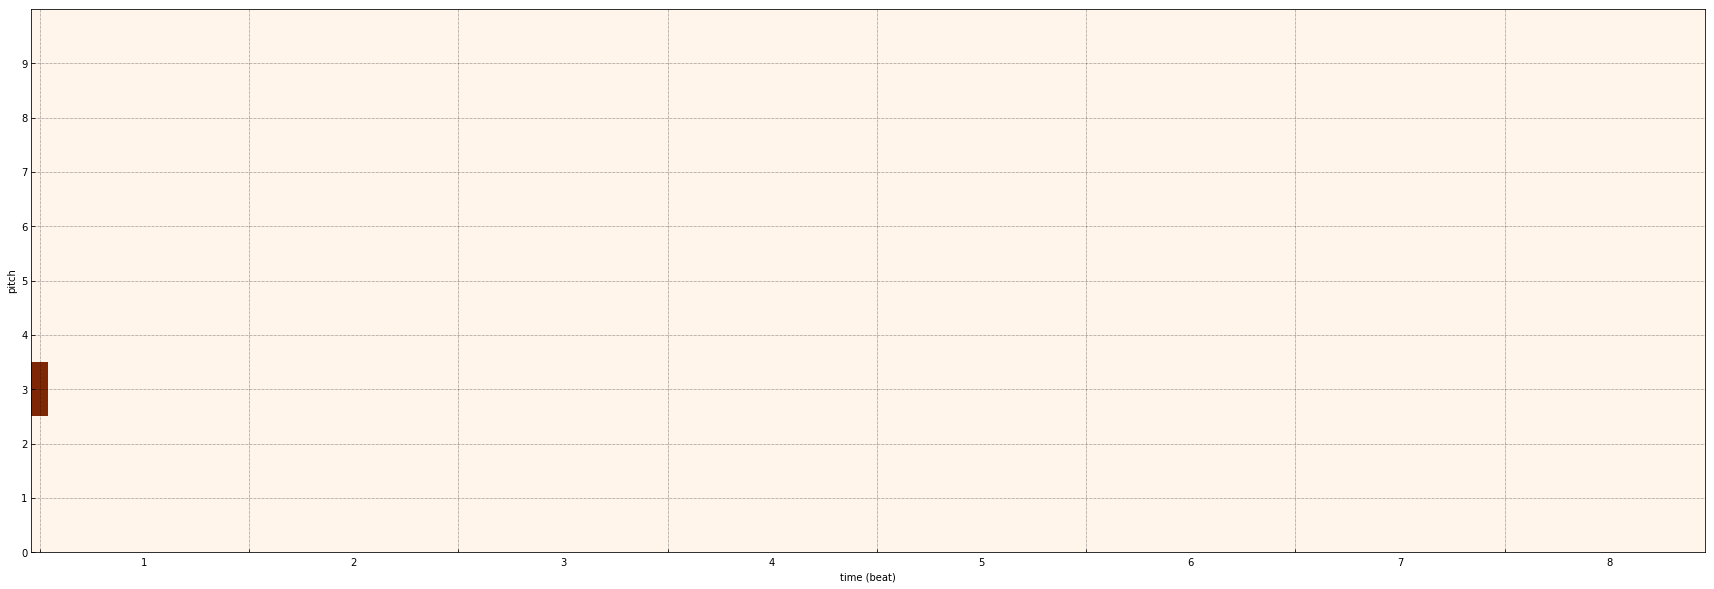

0.9576133 0.00012310372


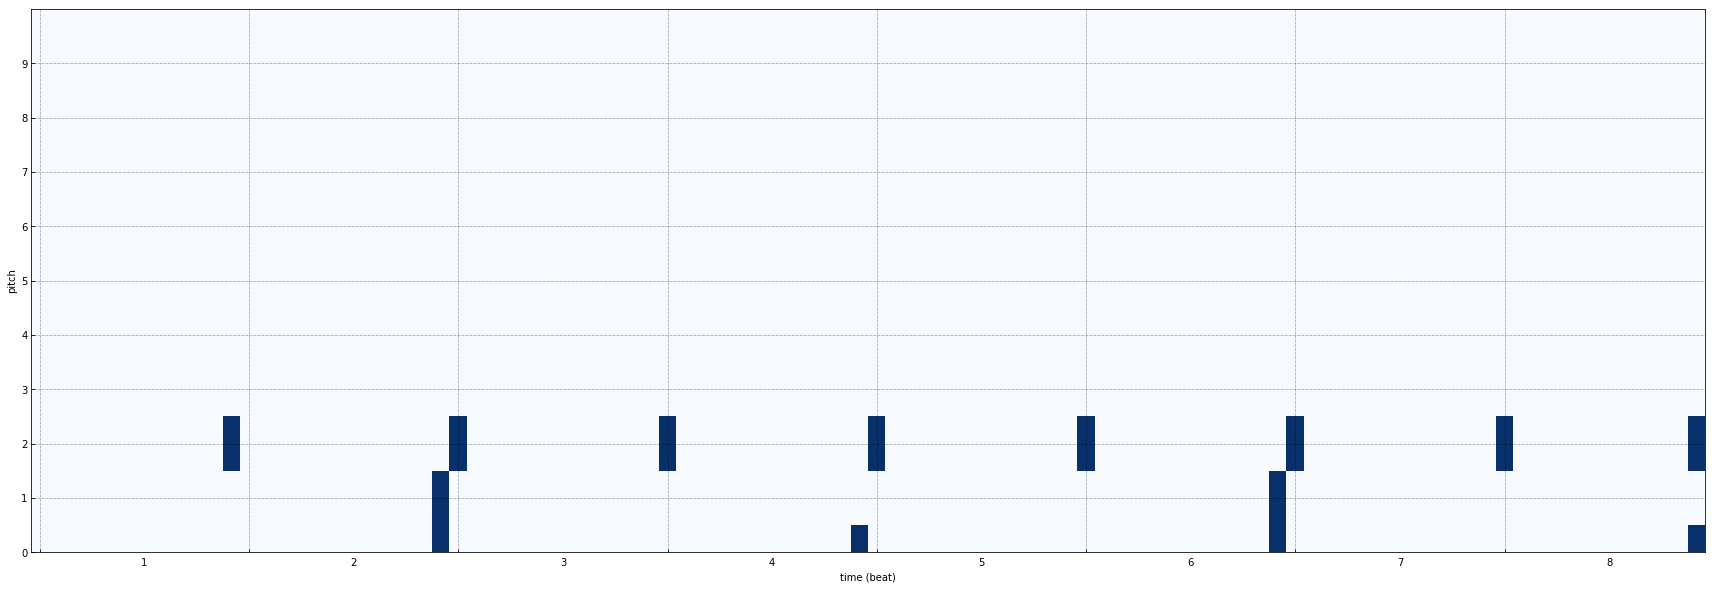

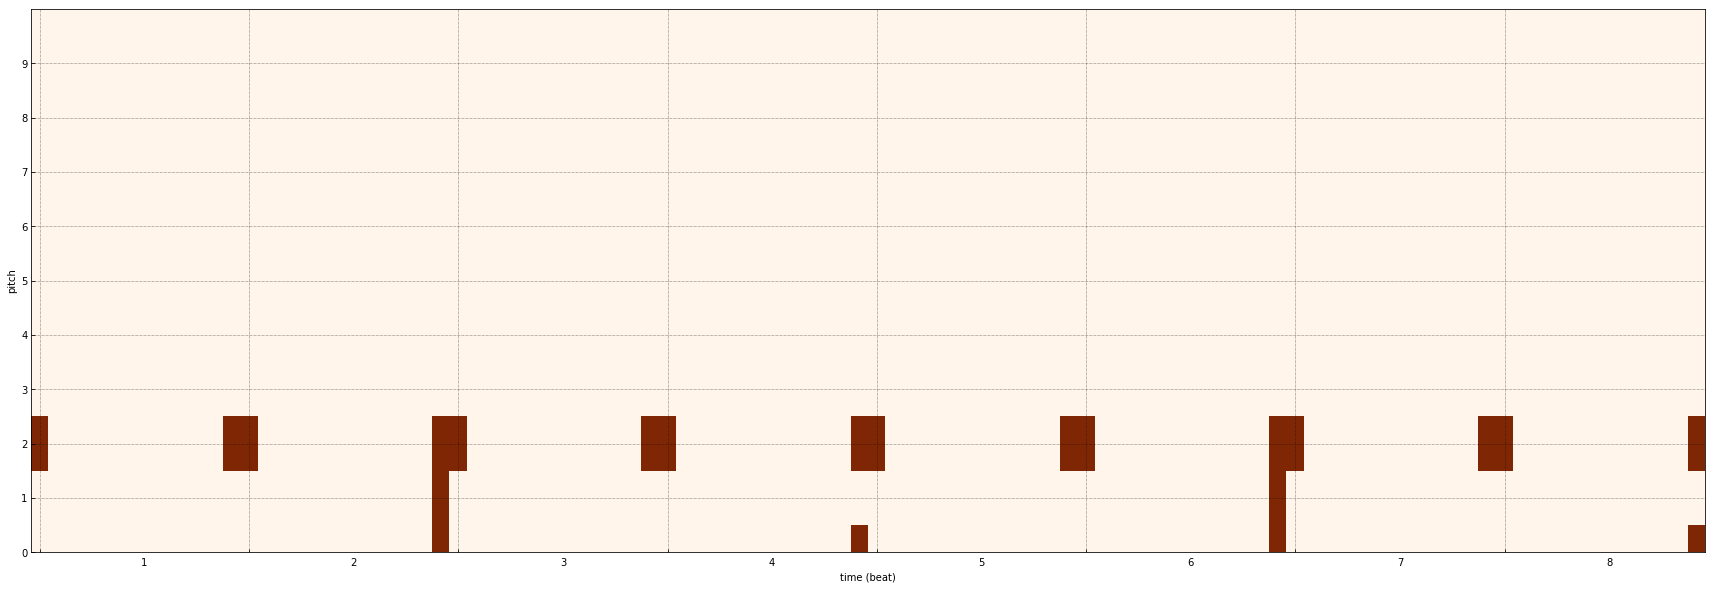

1.0 7.697937e-06


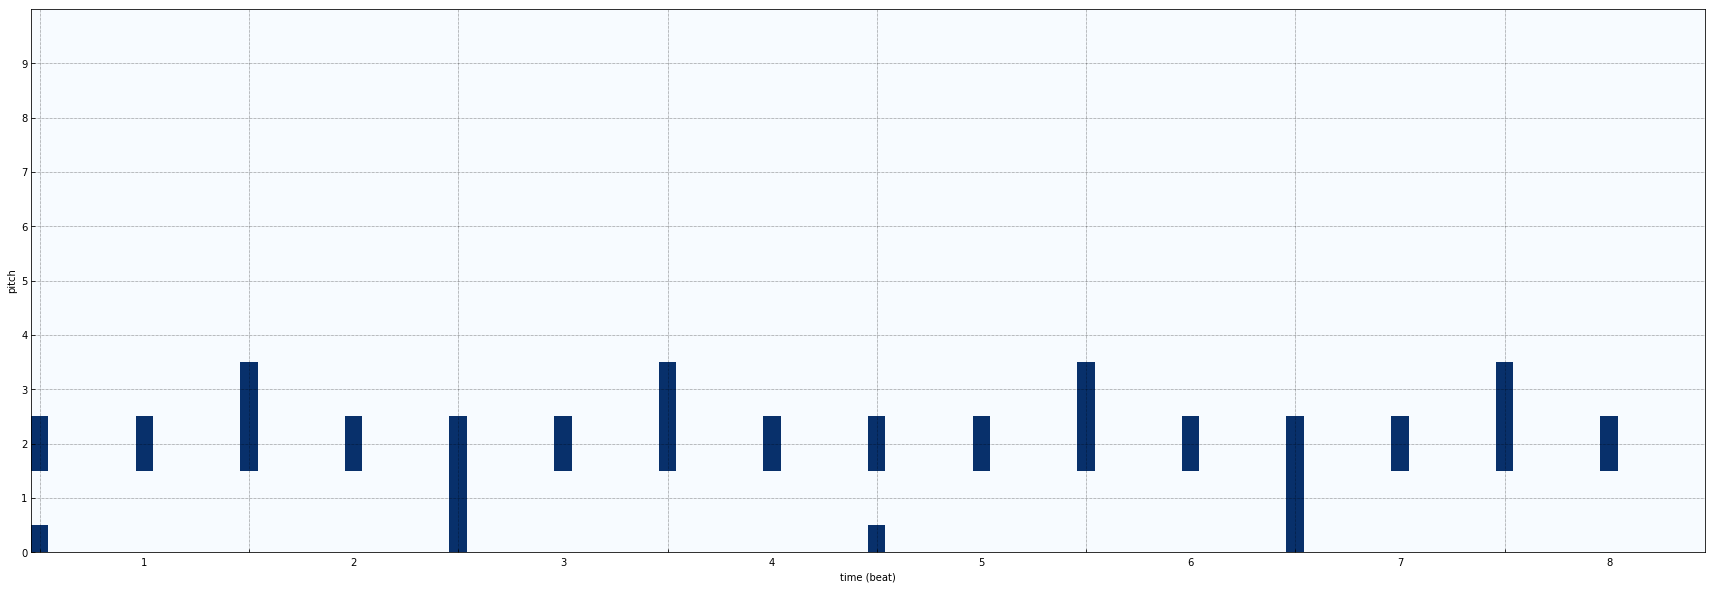

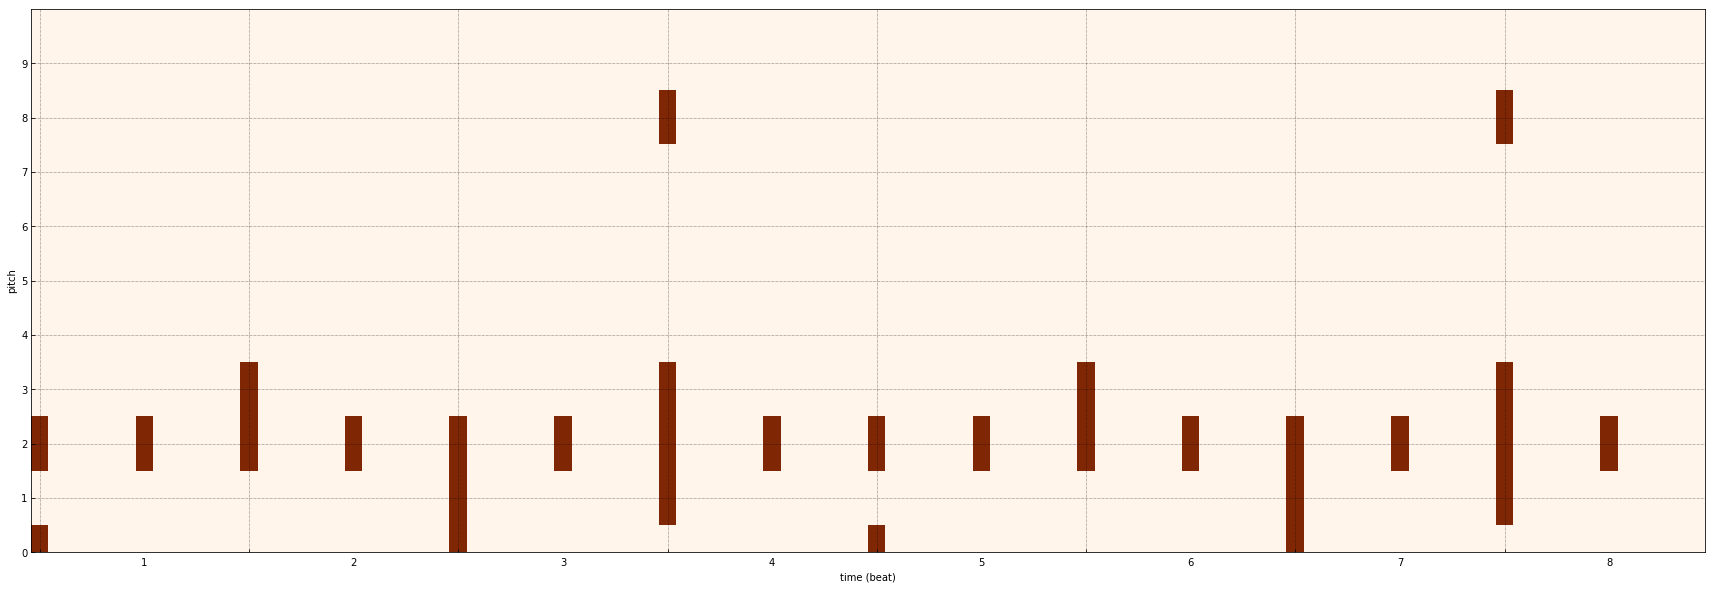

0.9999988 1.4269493e-05


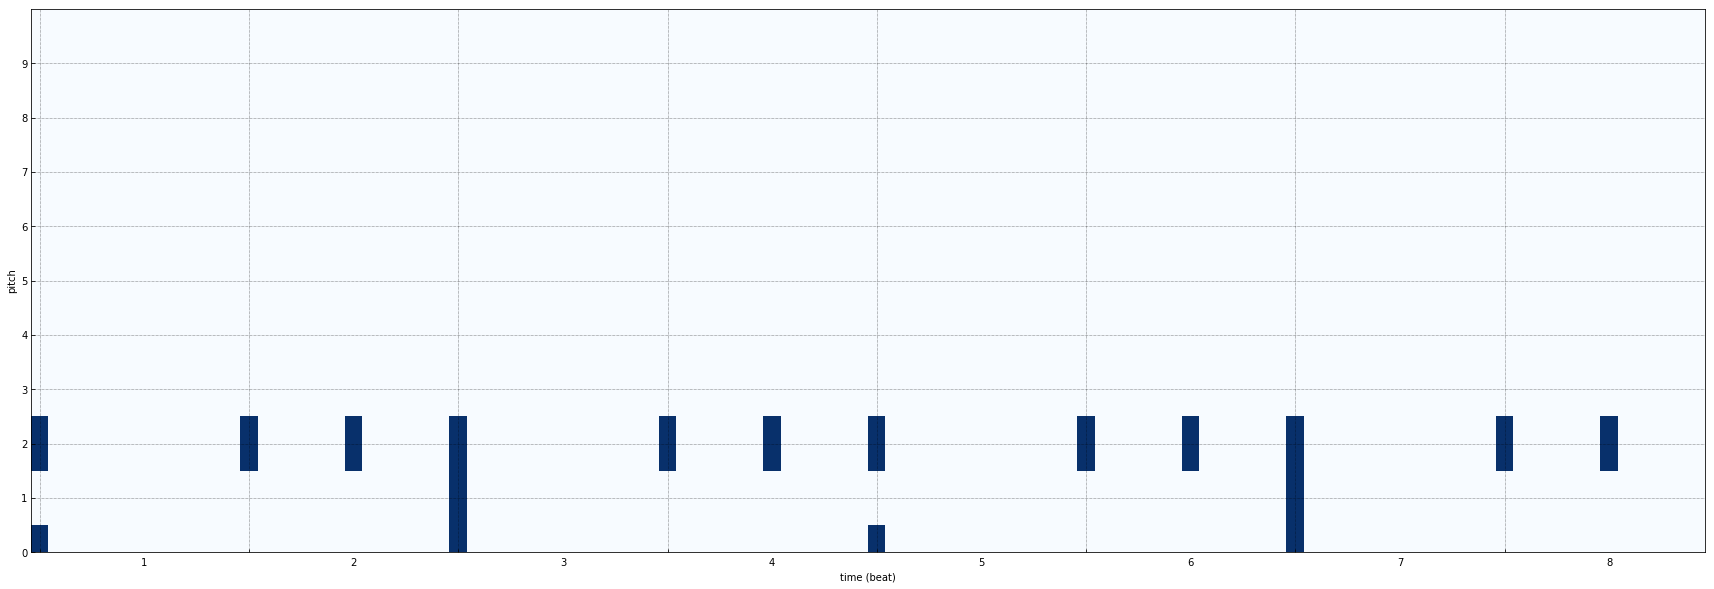

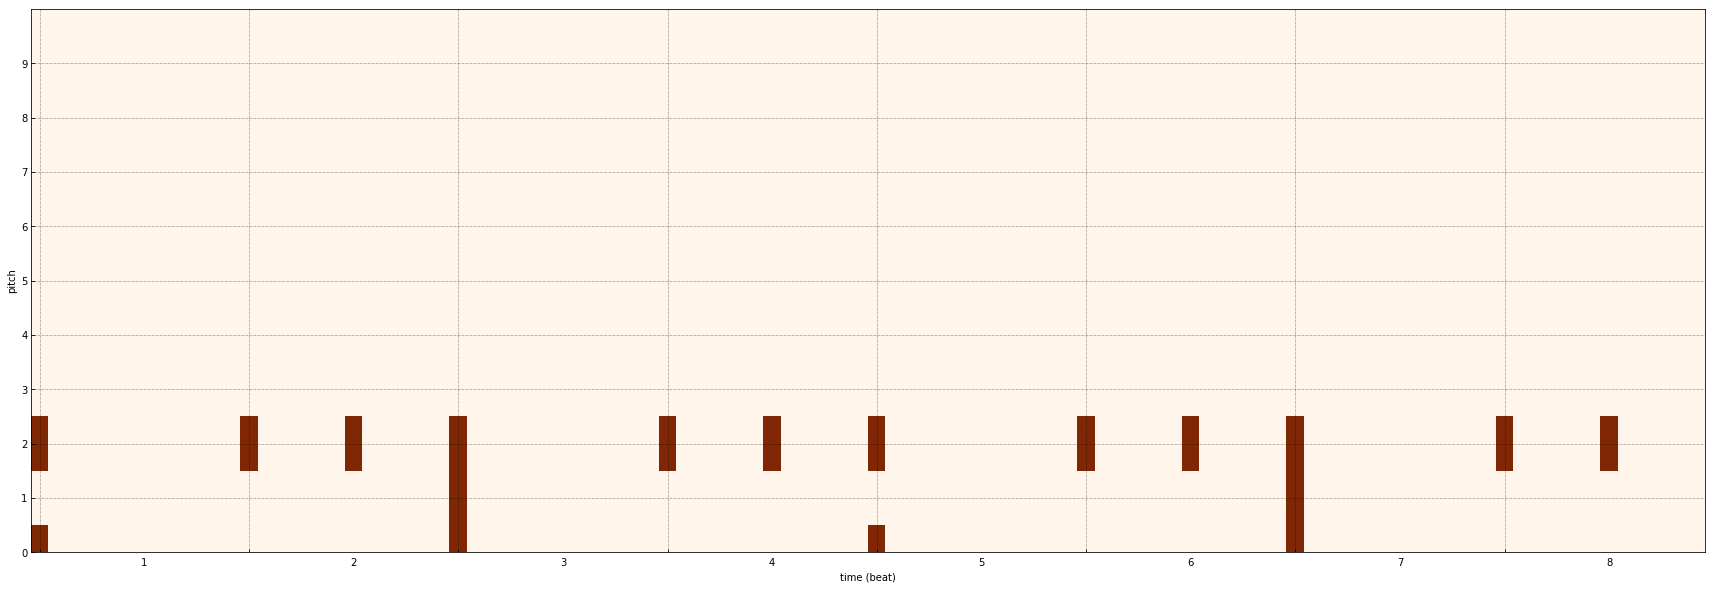

0.999987 1.7596501e-06


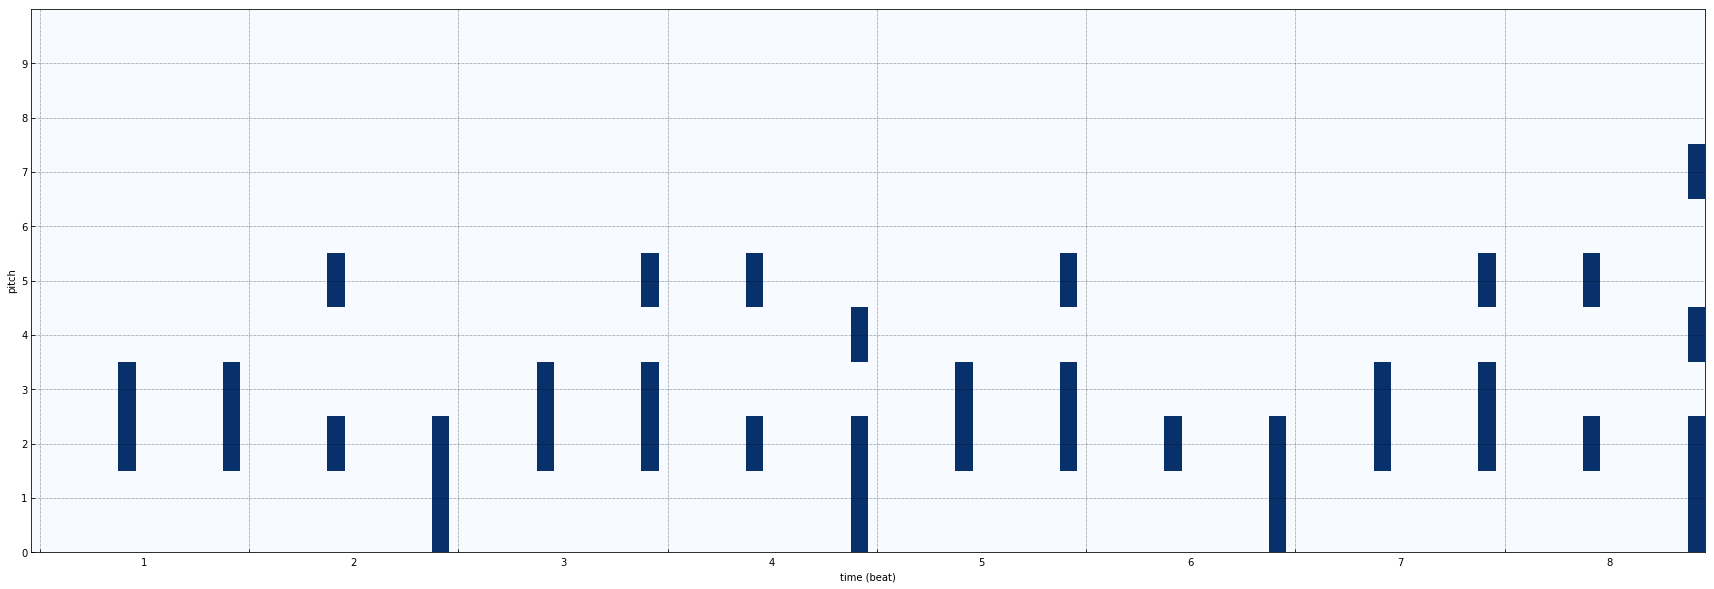

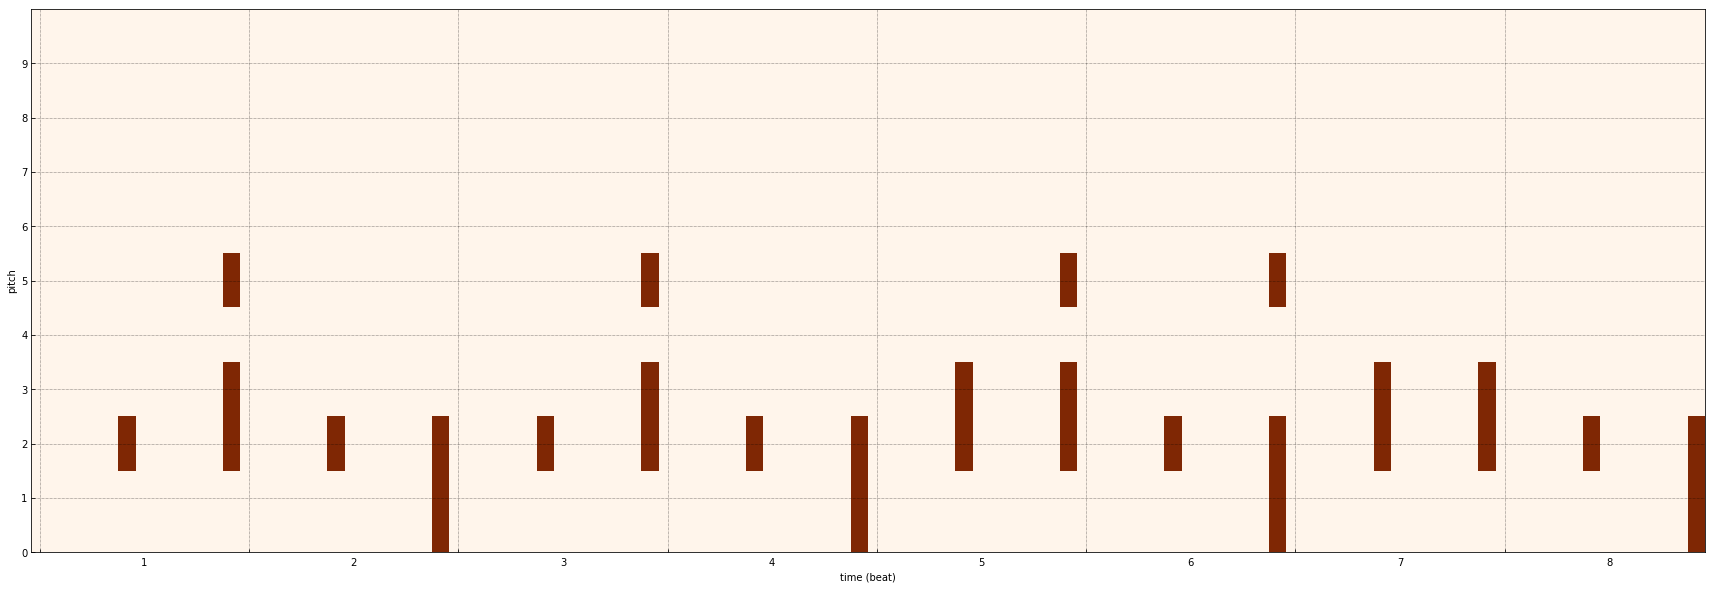

In [15]:
for batch_i, data in enumerate(test_loader):
    if batch_i > 0:
        break
    with torch.no_grad():
        data = Variable(data[0]).type(torch.float32).to(device)
        data_out = vae(data)
        
        
        for i in range(len(data)):
            if i < 20:
                data_i = data[i].cpu().data.numpy()
                data_o = data_out[i].cpu().data.numpy()
                print(data_o.max(), data_o.min())
                data_o = np.where(data_o > 0.2, 1, 0)
                pltReducedDrumTrack(data_i)
                pltReducedDrumTrack(data_o, cmap='Oranges')